In [1]:
import numpy as np
from torch import nn
from torch import optim

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.attention_classifier_training import train_attention_classifier_with_cv, train_attention_classifier, evaluate_attention_classifier
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_folds
import lib.torch_device as tdev
import torch.optim.lr_scheduler as lr_scheduler

%load_ext autoreload
%autoreload 2

In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_train, labels_train, data_test, labels_test = split(*load_all_data('dataset'), seed=69421)

In [4]:
data_train, data_test = remove_correlated_columns(data_train, data_test)

correlated_columns_to_drop = array([  0,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214

In [5]:
data_train.shape

(960, 100, 264)

In [6]:
set_random_seed(42)
subset_indices = [
    bird * data_train.shape[0] // 6 + sample_nr
    for bird in range(6)
    for sample_nr in range(10)
]
# data_train_subset = data_train[subset_indices, :, :]
# labels_train_subset = labels_train[subset_indices, :]
data_train_subset = data_train[subset_indices, :, :]
labels_train_subset = labels_train[subset_indices, :]
print(data_train_subset.shape)
print(labels_train_subset.shape)

(60, 100, 264)
(60, 100)


## Hyper Parameters

In [7]:
hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_train.shape[-1],
    out_features=NUM_CLASSES,
    
    self_attention=True,
    d_model=60,
    num_heads=12,
    stack_size=1,
    dropout=0.1,
    
    in_linear_hidden_out_features=[48, 48],
    out_linear_hidden_out_features=[64],
    
    linear_activation_provider=lambda: nn.LeakyReLU(),
)

In [45]:
EPOCH_MULTIPLIER = 0.5

training_hyper_parameters = TrainingHyperParameters(
    batch_size=32,
    
    optimizer_provider=lambda model, lr: optim.Adamax(
        model.parameters(),
        lr=lr,
        betas=(0.9, 0.98),
        eps=1e-9
    ),
    
    num_epochs=int(100 * EPOCH_MULTIPLIER),
    lr=1e-2,
    lr_scheduler_provider=lambda optimizer: lr_scheduler.MultiStepLR(
        optimizer, 
        milestones=[int(m * EPOCH_MULTIPLIER) for m in [8, 20, 50, 90]],
        gamma=0.5
    )
)

## Training

Training fold 0
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.8275,  9.6494, 10.6295, 36.9184, 17.7606, 19.8364],
       device='cuda:0')
Training Epoch 0  /50 : lr = 0.01, avg_loss = 0.000500, num_samples = 86400, num_correct =  9639, acc = 0.111562, bacc = 0.282869
Evaluation Epoch 0  /50 : avg_loss = 0.015948, num_samples =  9600, num_correct =  2241, acc = 0.233437, bacc = 0.574205
Training Epoch 1  /50 : lr = 0.01, avg_loss = 0.000302, num_samples = 86400, num_correct = 19847, acc = 0.229711, bacc = 0.575126
Evaluation Epoch 1  /50 : avg_loss = 0.033663, num_samples =  9600, num_correct =  4185, acc = 0.435937, bacc = 0.735503
Training Epoch 2  /50 : lr = 0.01, avg_loss = 0.000197, num_samples = 86400, num_correct = 44419, acc = 0.514109, bacc = 0.770508
Evaluation Epoch 2  /50 : avg_loss = 0.102852, num_samples =  9600, num_correct =  5264, acc = 0.548333, bacc = 0.761396
Training Epoch 3  /50 : lr = 0.005, avg_loss = 0.000147, num_samples =

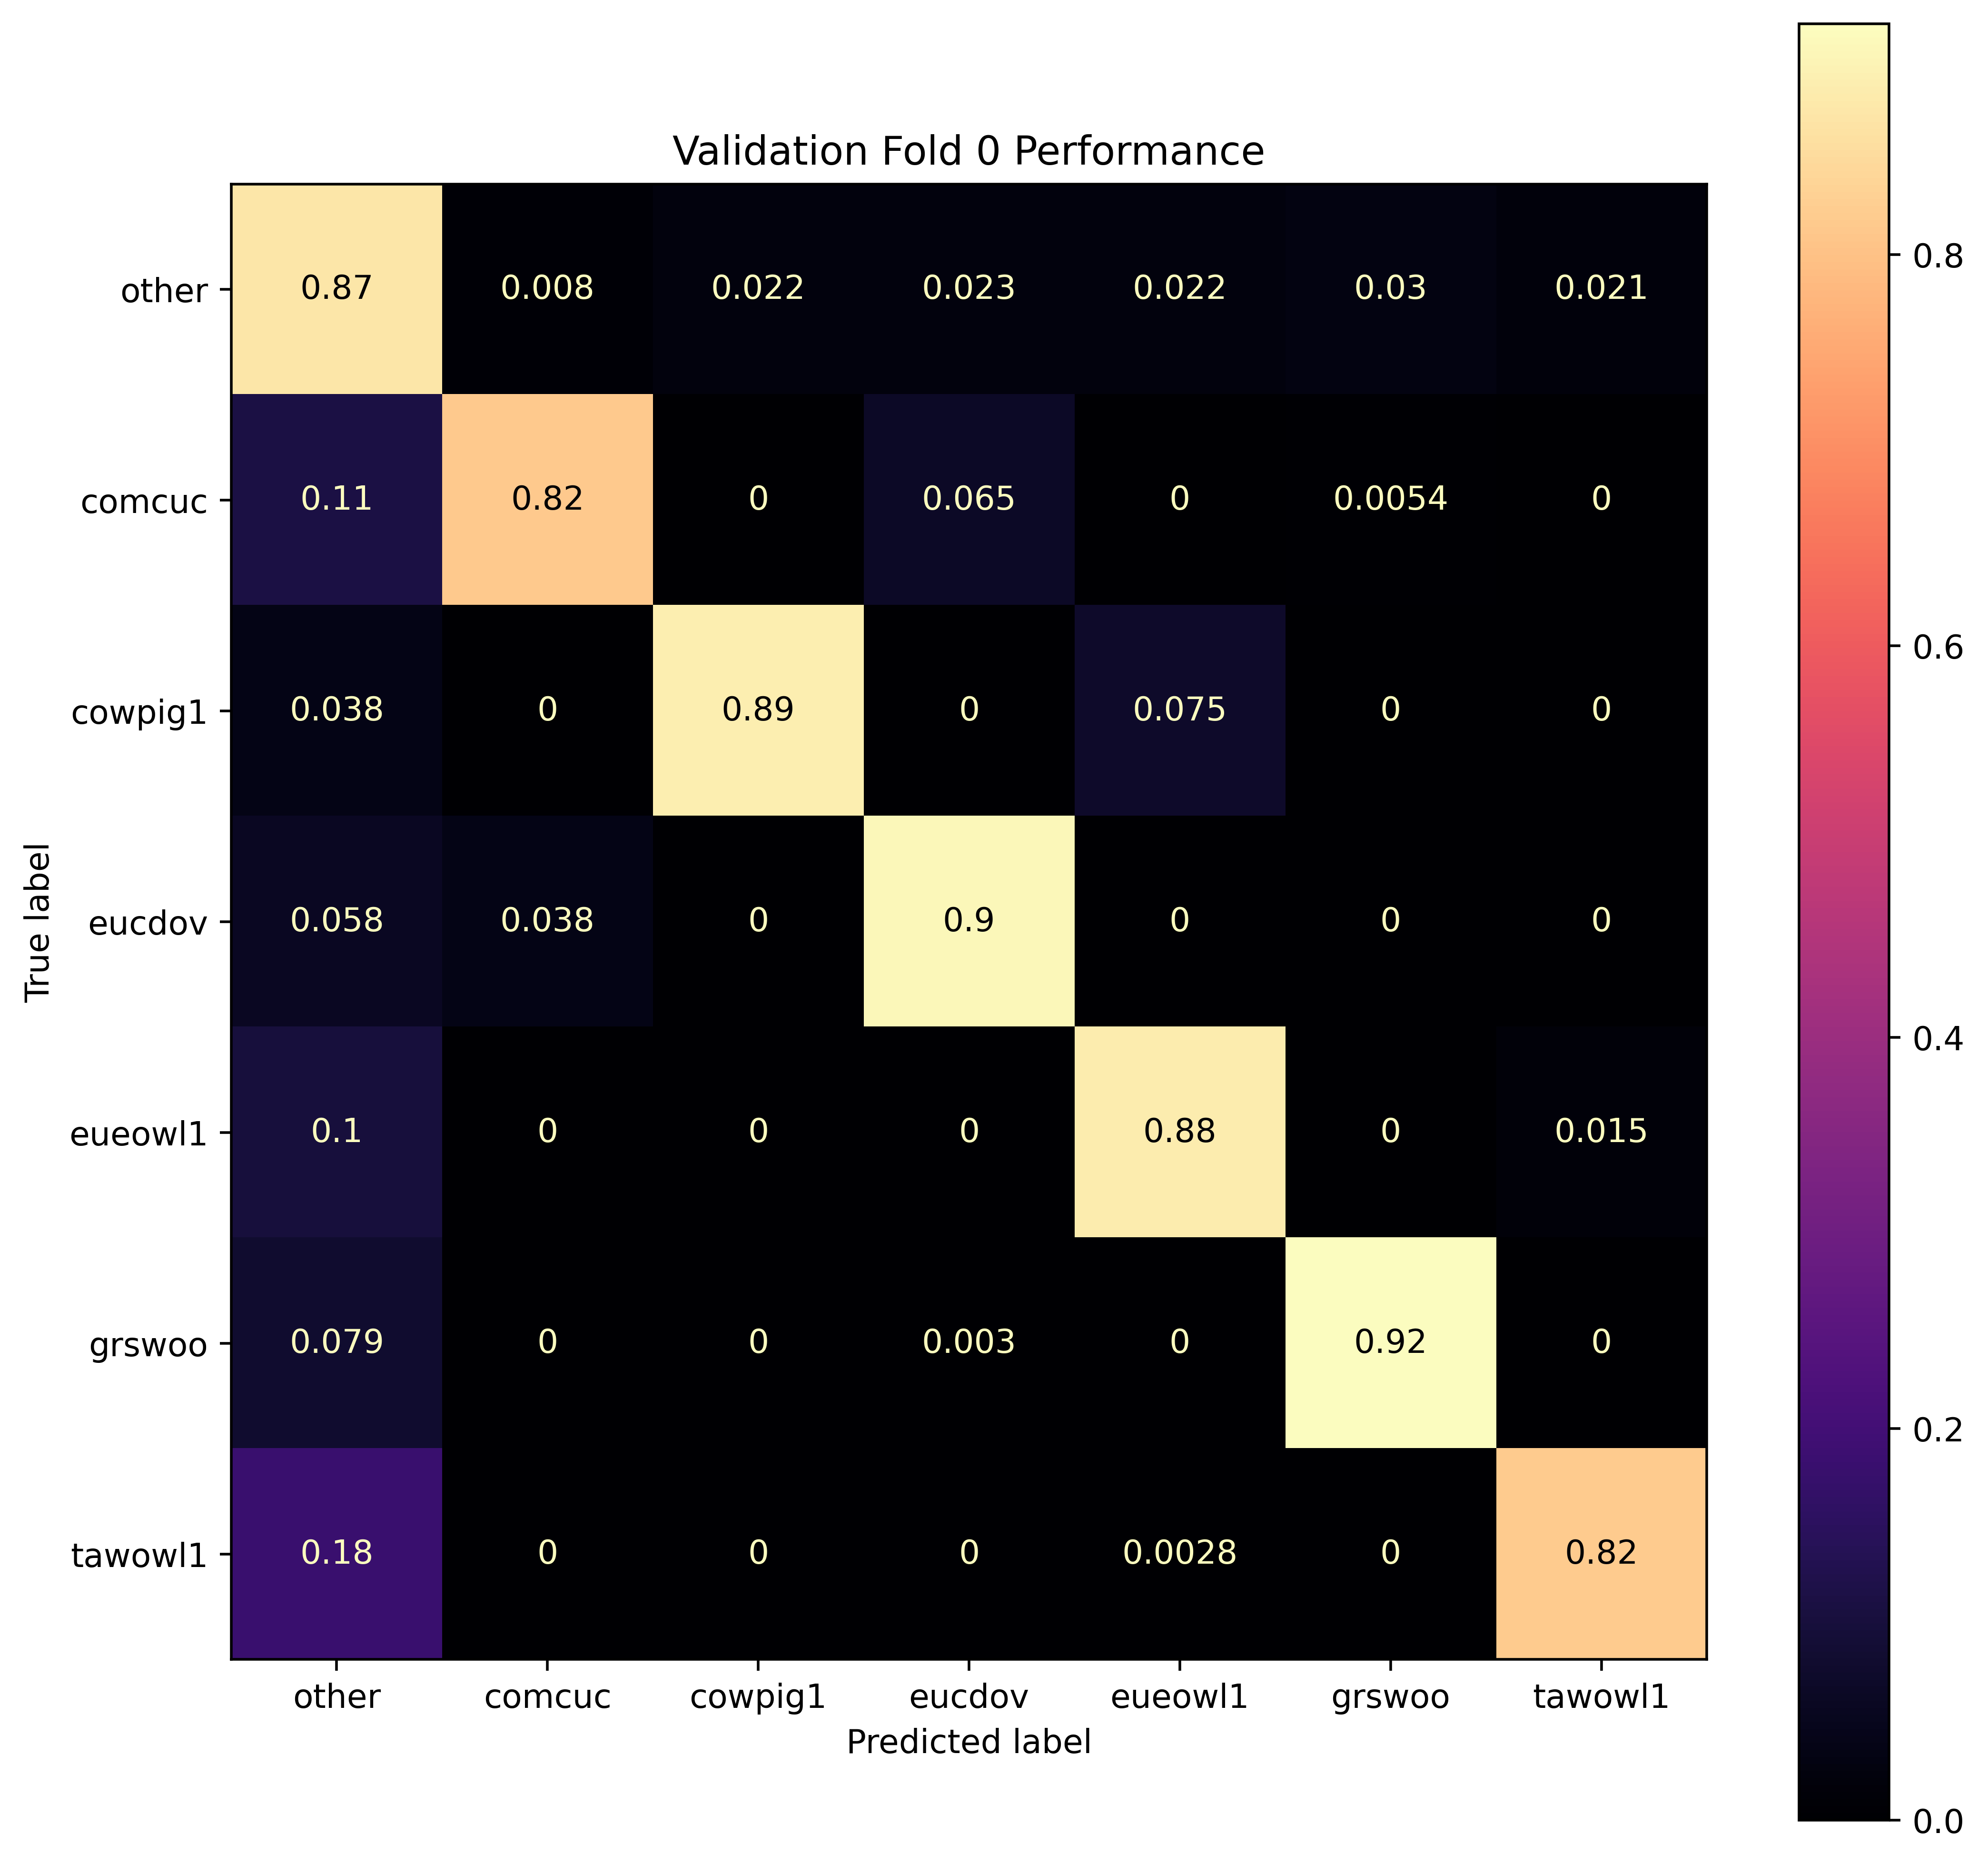

Saved model with scaler as "attention_classifier cv2023-05-17_20.02 fold-0"
Training fold 1
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.3660,  9.3527, 10.3101, 35.4703, 17.9944, 19.5368],
       device='cuda:0')
Training Epoch 0  /50 : lr = 0.01, avg_loss = 0.000500, num_samples = 86400, num_correct =  9903, acc = 0.114618, bacc = 0.295586
Evaluation Epoch 0  /50 : avg_loss = 0.000472, num_samples =  9600, num_correct =  1997, acc = 0.208021, bacc = 0.474682
Training Epoch 1  /50 : lr = 0.01, avg_loss = 0.000368, num_samples = 86400, num_correct = 17767, acc = 0.205637, bacc = 0.521108
Evaluation Epoch 1  /50 : avg_loss = 0.000405, num_samples =  9600, num_correct =  3472, acc = 0.361667, bacc = 0.633358
Training Epoch 2  /50 : lr = 0.01, avg_loss = 0.000236, num_samples = 86400, num_correct = 34957, acc = 0.404595, bacc = 0.707316
Evaluation Epoch 2  /50 : avg_loss = 0.000325, num_samples =  9600, num_correct =  5553, acc = 0.578438, bacc = 0.7

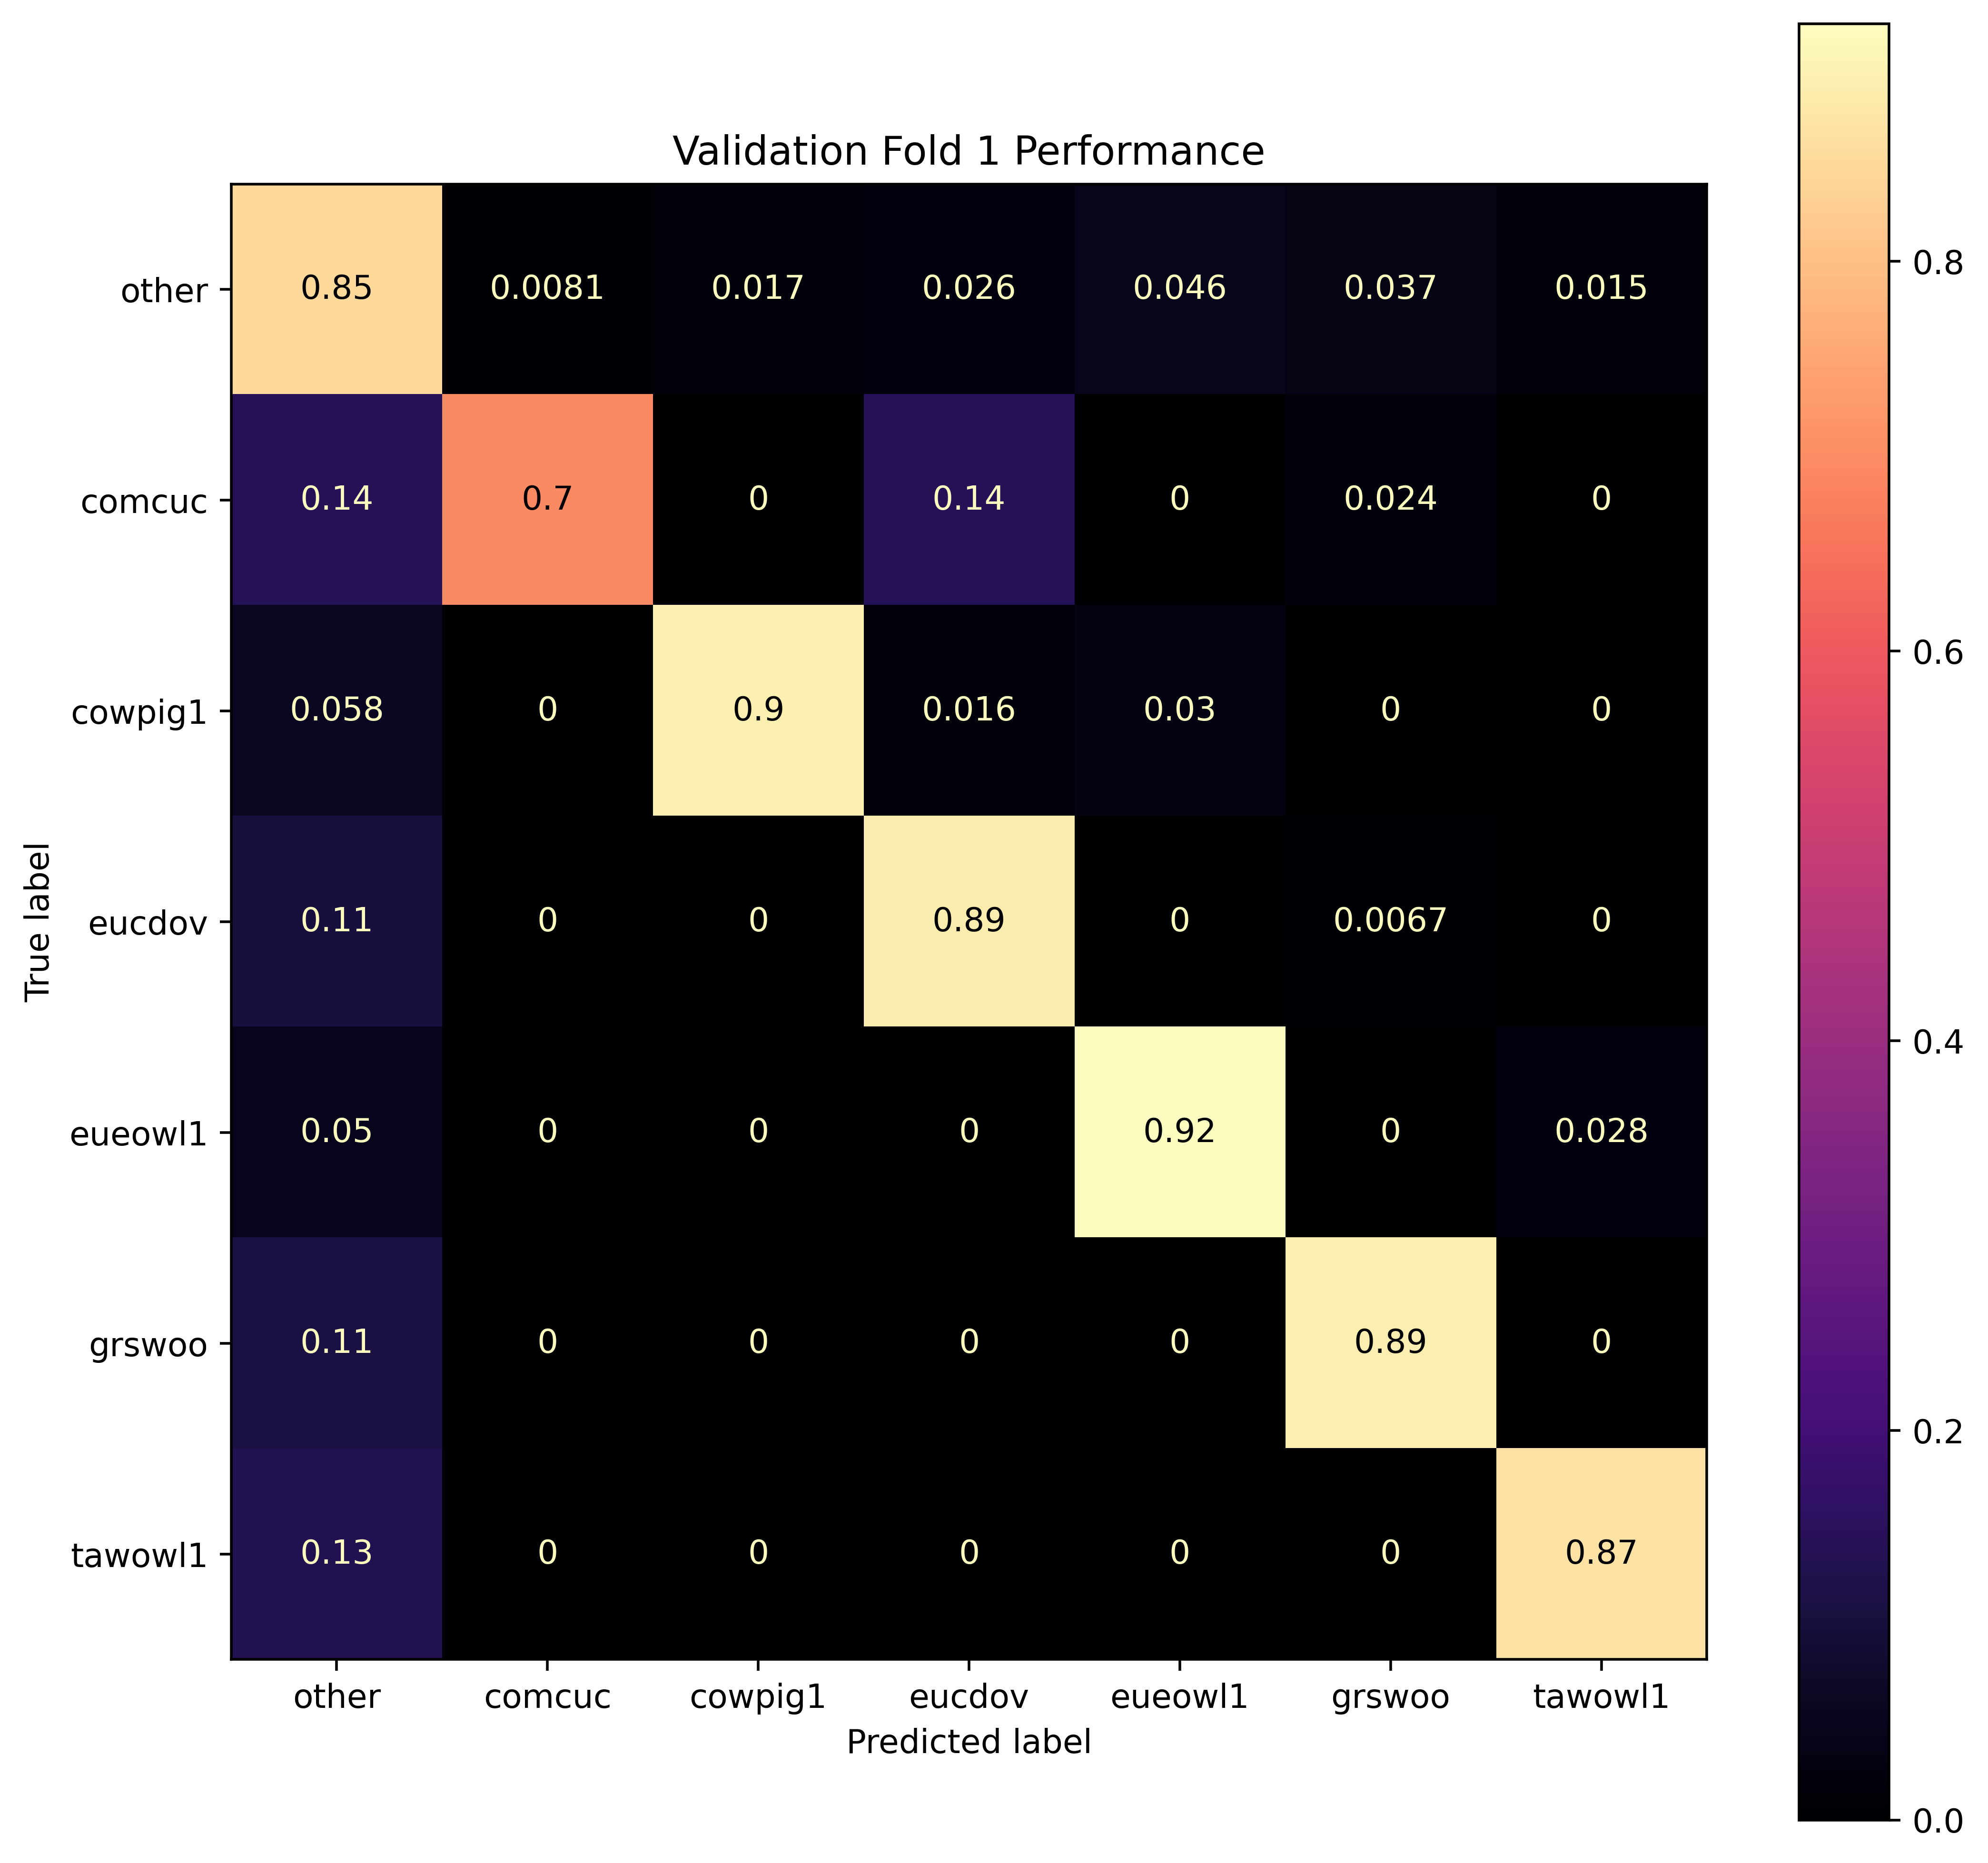

Saved model with scaler as "attention_classifier cv2023-05-17_20.02 fold-1"
Training fold 2
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.2621,  9.1518, 10.3538, 36.6018, 18.4547, 19.1561],
       device='cuda:0')
Training Epoch 0  /50 : lr = 0.01, avg_loss = 0.000518, num_samples = 86400, num_correct = 10164, acc = 0.117639, bacc = 0.255477
Evaluation Epoch 0  /50 : avg_loss = 0.000483, num_samples =  9600, num_correct =  1860, acc = 0.193750, bacc = 0.507764
Training Epoch 1  /50 : lr = 0.01, avg_loss = 0.000339, num_samples = 86400, num_correct = 18865, acc = 0.218345, bacc = 0.574014
Evaluation Epoch 1  /50 : avg_loss = 0.000461, num_samples =  9600, num_correct =  2674, acc = 0.278542, bacc = 0.710841
Training Epoch 2  /50 : lr = 0.01, avg_loss = 0.000201, num_samples = 86400, num_correct = 31127, acc = 0.360266, bacc = 0.771937
Evaluation Epoch 2  /50 : avg_loss = 0.000453, num_samples =  9600, num_correct =  4827, acc = 0.502812, bacc = 0.8

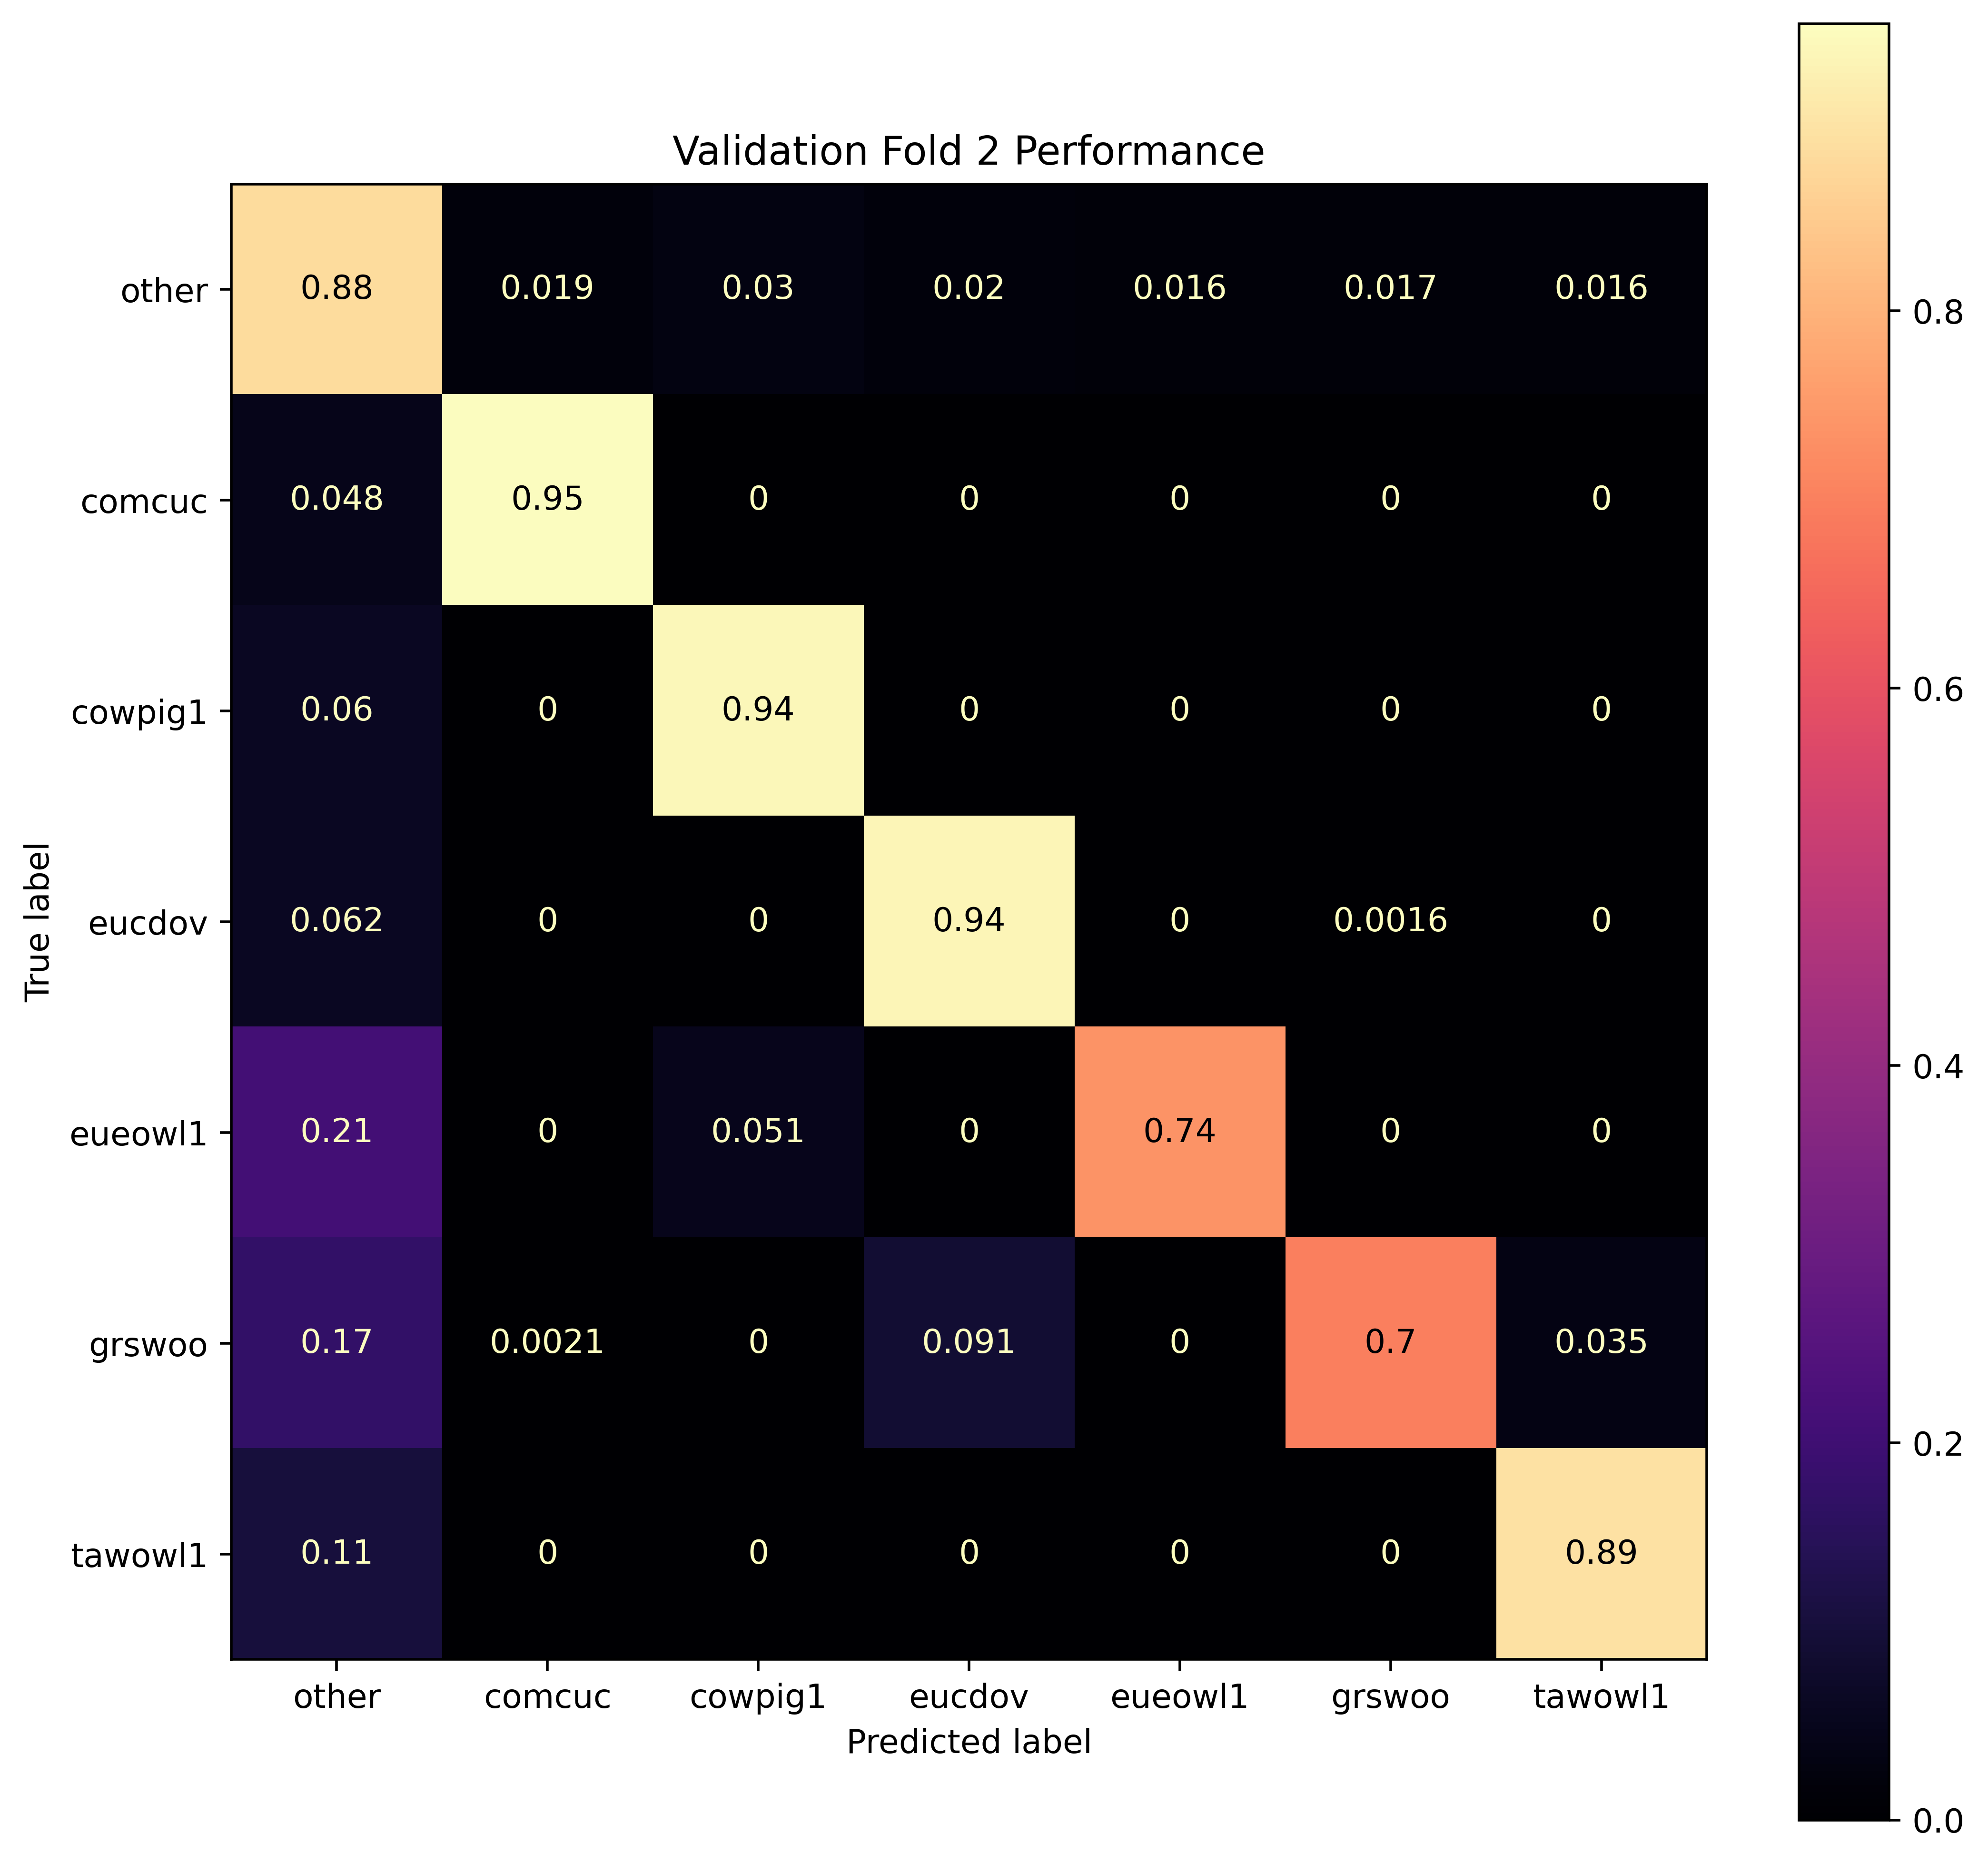

Saved model with scaler as "attention_classifier cv2023-05-17_20.02 fold-2"
Training fold 3
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.5361,  9.3948, 10.4847, 38.6121, 18.1551, 19.8071],
       device='cuda:0')
Training Epoch 0  /50 : lr = 0.01, avg_loss = 0.000495, num_samples = 86400, num_correct = 10023, acc = 0.116007, bacc = 0.321790
Evaluation Epoch 0  /50 : avg_loss = 0.000464, num_samples =  9600, num_correct =  1971, acc = 0.205313, bacc = 0.602722
Training Epoch 1  /50 : lr = 0.01, avg_loss = 0.000284, num_samples = 86400, num_correct = 21189, acc = 0.245243, bacc = 0.668527
Evaluation Epoch 1  /50 : avg_loss = 0.000418, num_samples =  9600, num_correct =  2951, acc = 0.307396, bacc = 0.760637
Training Epoch 2  /50 : lr = 0.01, avg_loss = 0.000186, num_samples = 86400, num_correct = 34602, acc = 0.400486, bacc = 0.776263
Evaluation Epoch 2  /50 : avg_loss = 0.000306, num_samples =  9600, num_correct =  5402, acc = 0.562708, bacc = 0.8

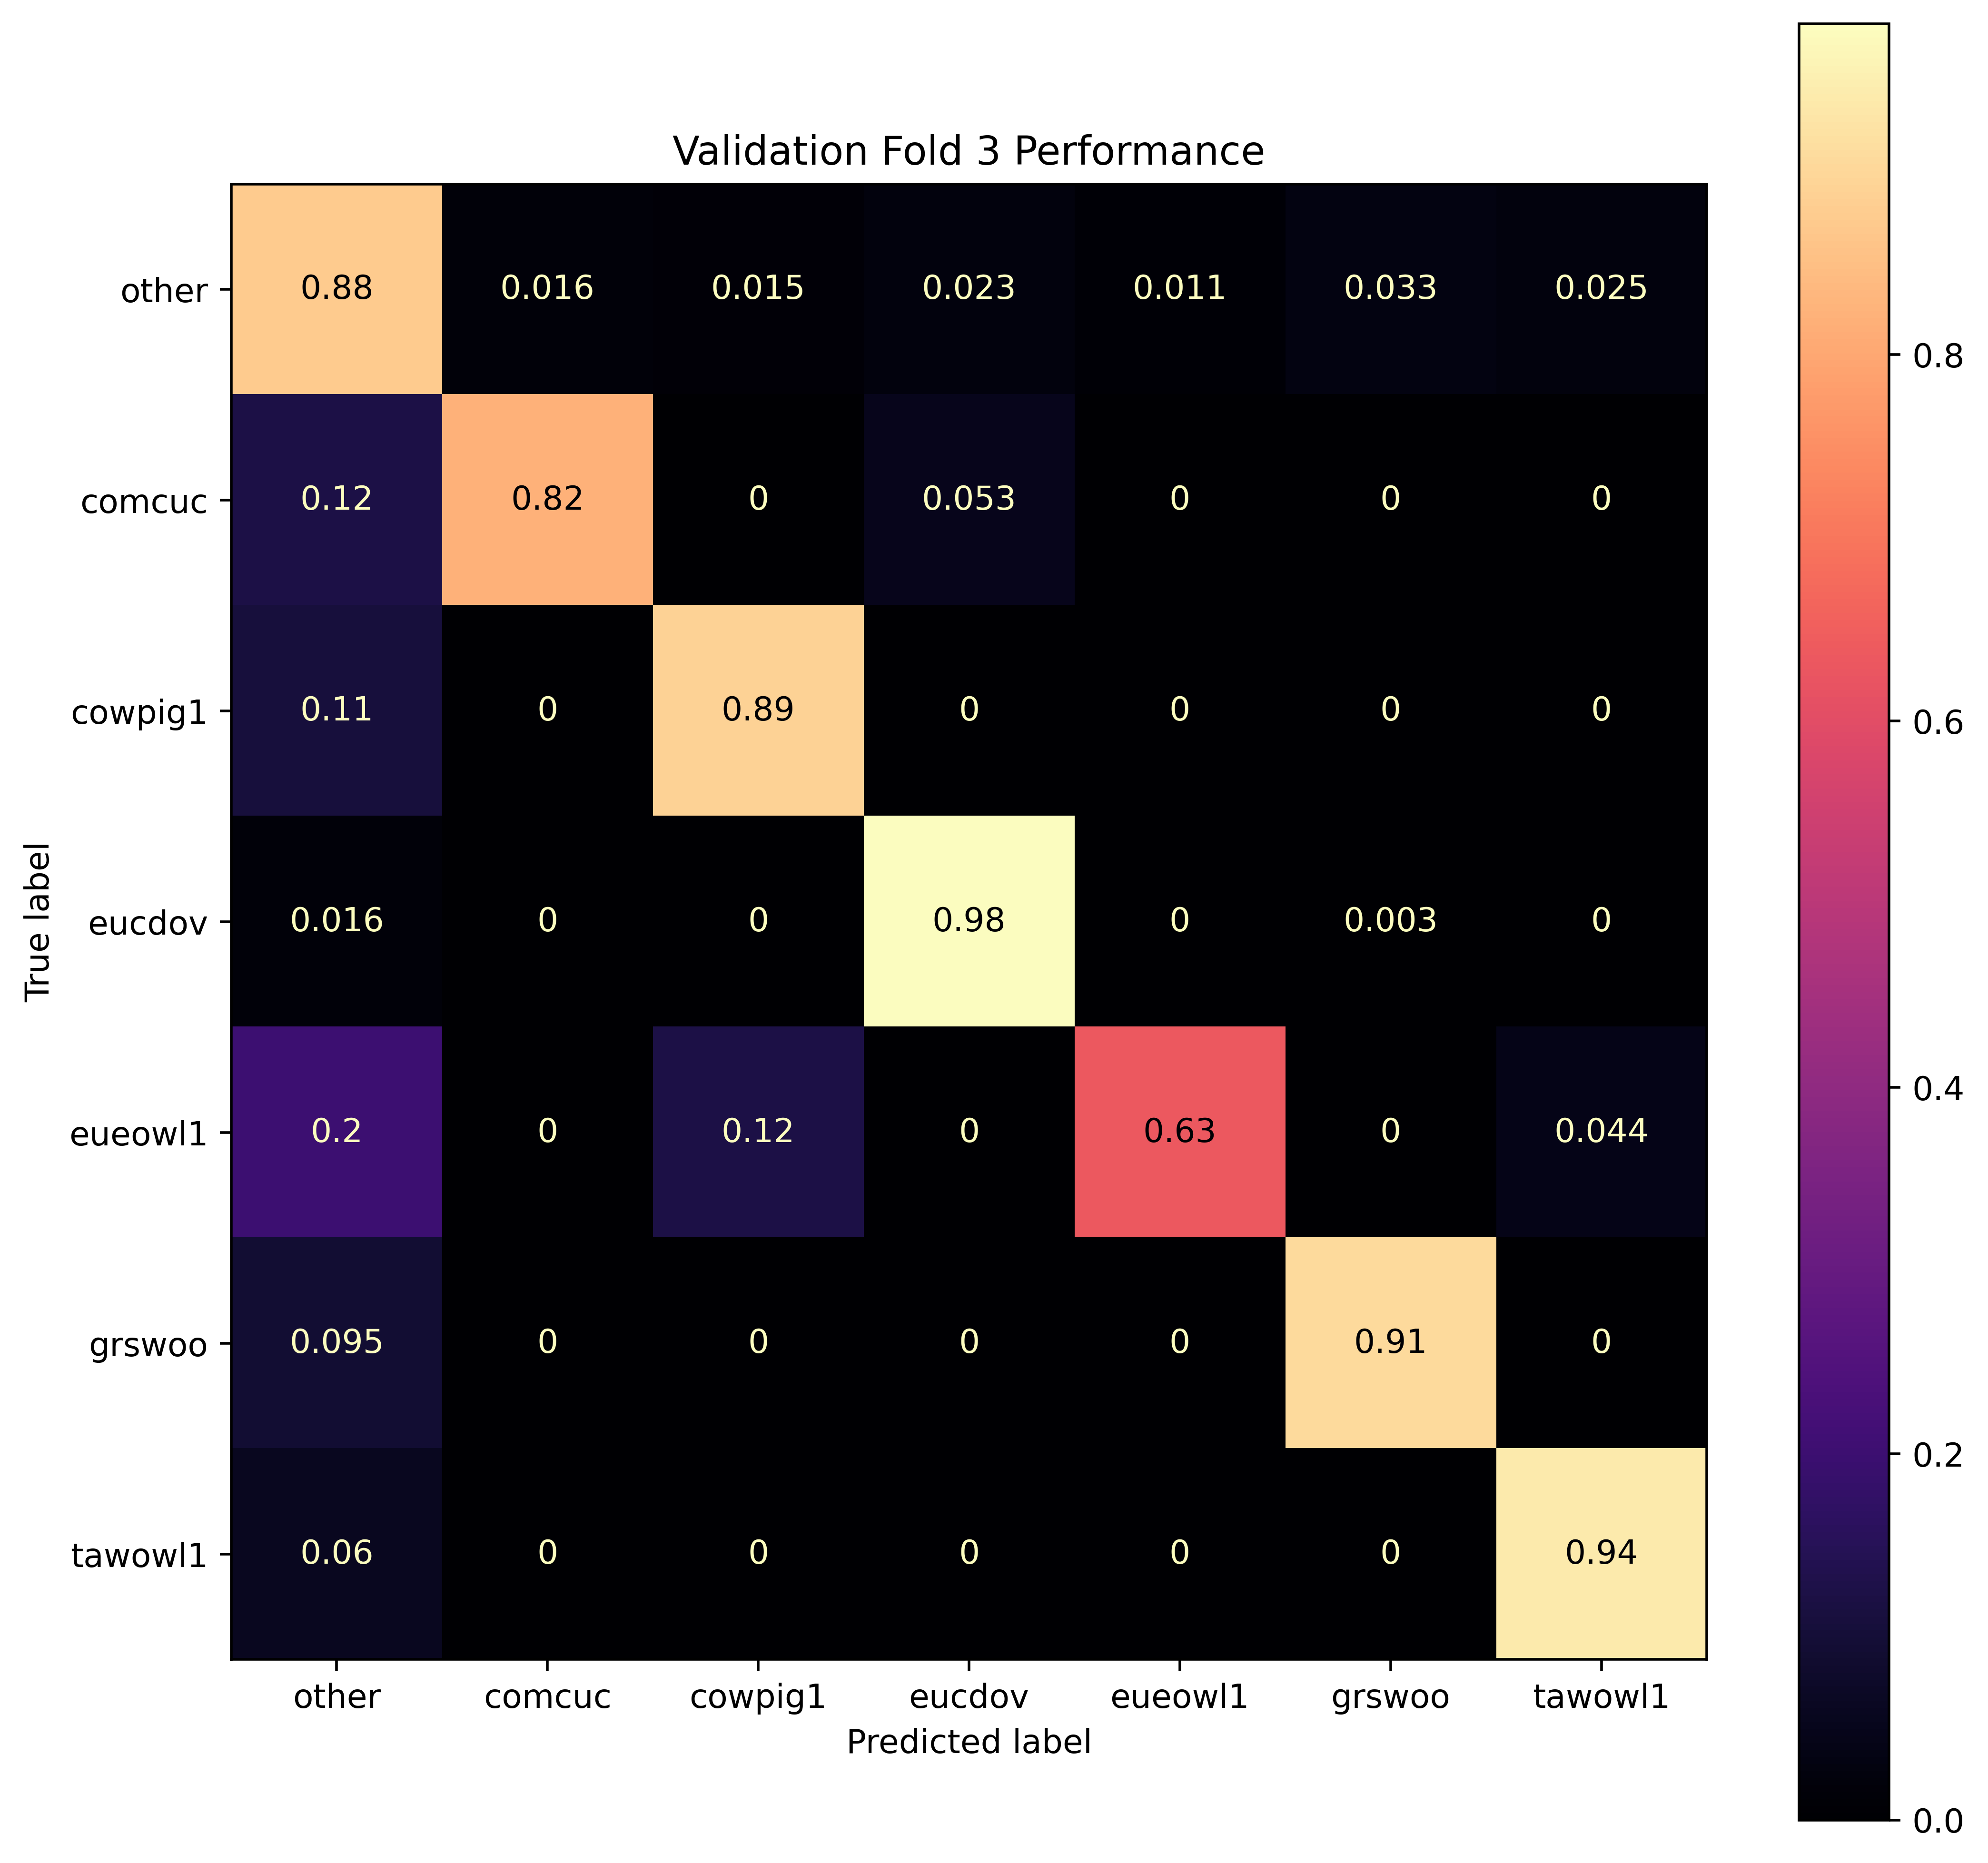

Saved model with scaler as "attention_classifier cv2023-05-17_20.02 fold-3"
Training fold 4
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.1846,  9.1787, 10.5581, 36.7640, 17.6949, 19.7380],
       device='cuda:0')
Training Epoch 0  /50 : lr = 0.01, avg_loss = 0.000504, num_samples = 86400, num_correct = 11084, acc = 0.128287, bacc = 0.227524
Evaluation Epoch 0  /50 : avg_loss = 0.000509, num_samples =  9600, num_correct =  1045, acc = 0.108854, bacc = 0.342622
Training Epoch 1  /50 : lr = 0.01, avg_loss = 0.000361, num_samples = 86400, num_correct = 14532, acc = 0.168194, bacc = 0.507819
Evaluation Epoch 1  /50 : avg_loss = 0.000469, num_samples =  9600, num_correct =  2381, acc = 0.248021, bacc = 0.615251
Training Epoch 2  /50 : lr = 0.01, avg_loss = 0.000260, num_samples = 86400, num_correct = 30141, acc = 0.348854, bacc = 0.696291
Evaluation Epoch 2  /50 : avg_loss = 0.000410, num_samples =  9600, num_correct =  4939, acc = 0.514479, bacc = 0.7

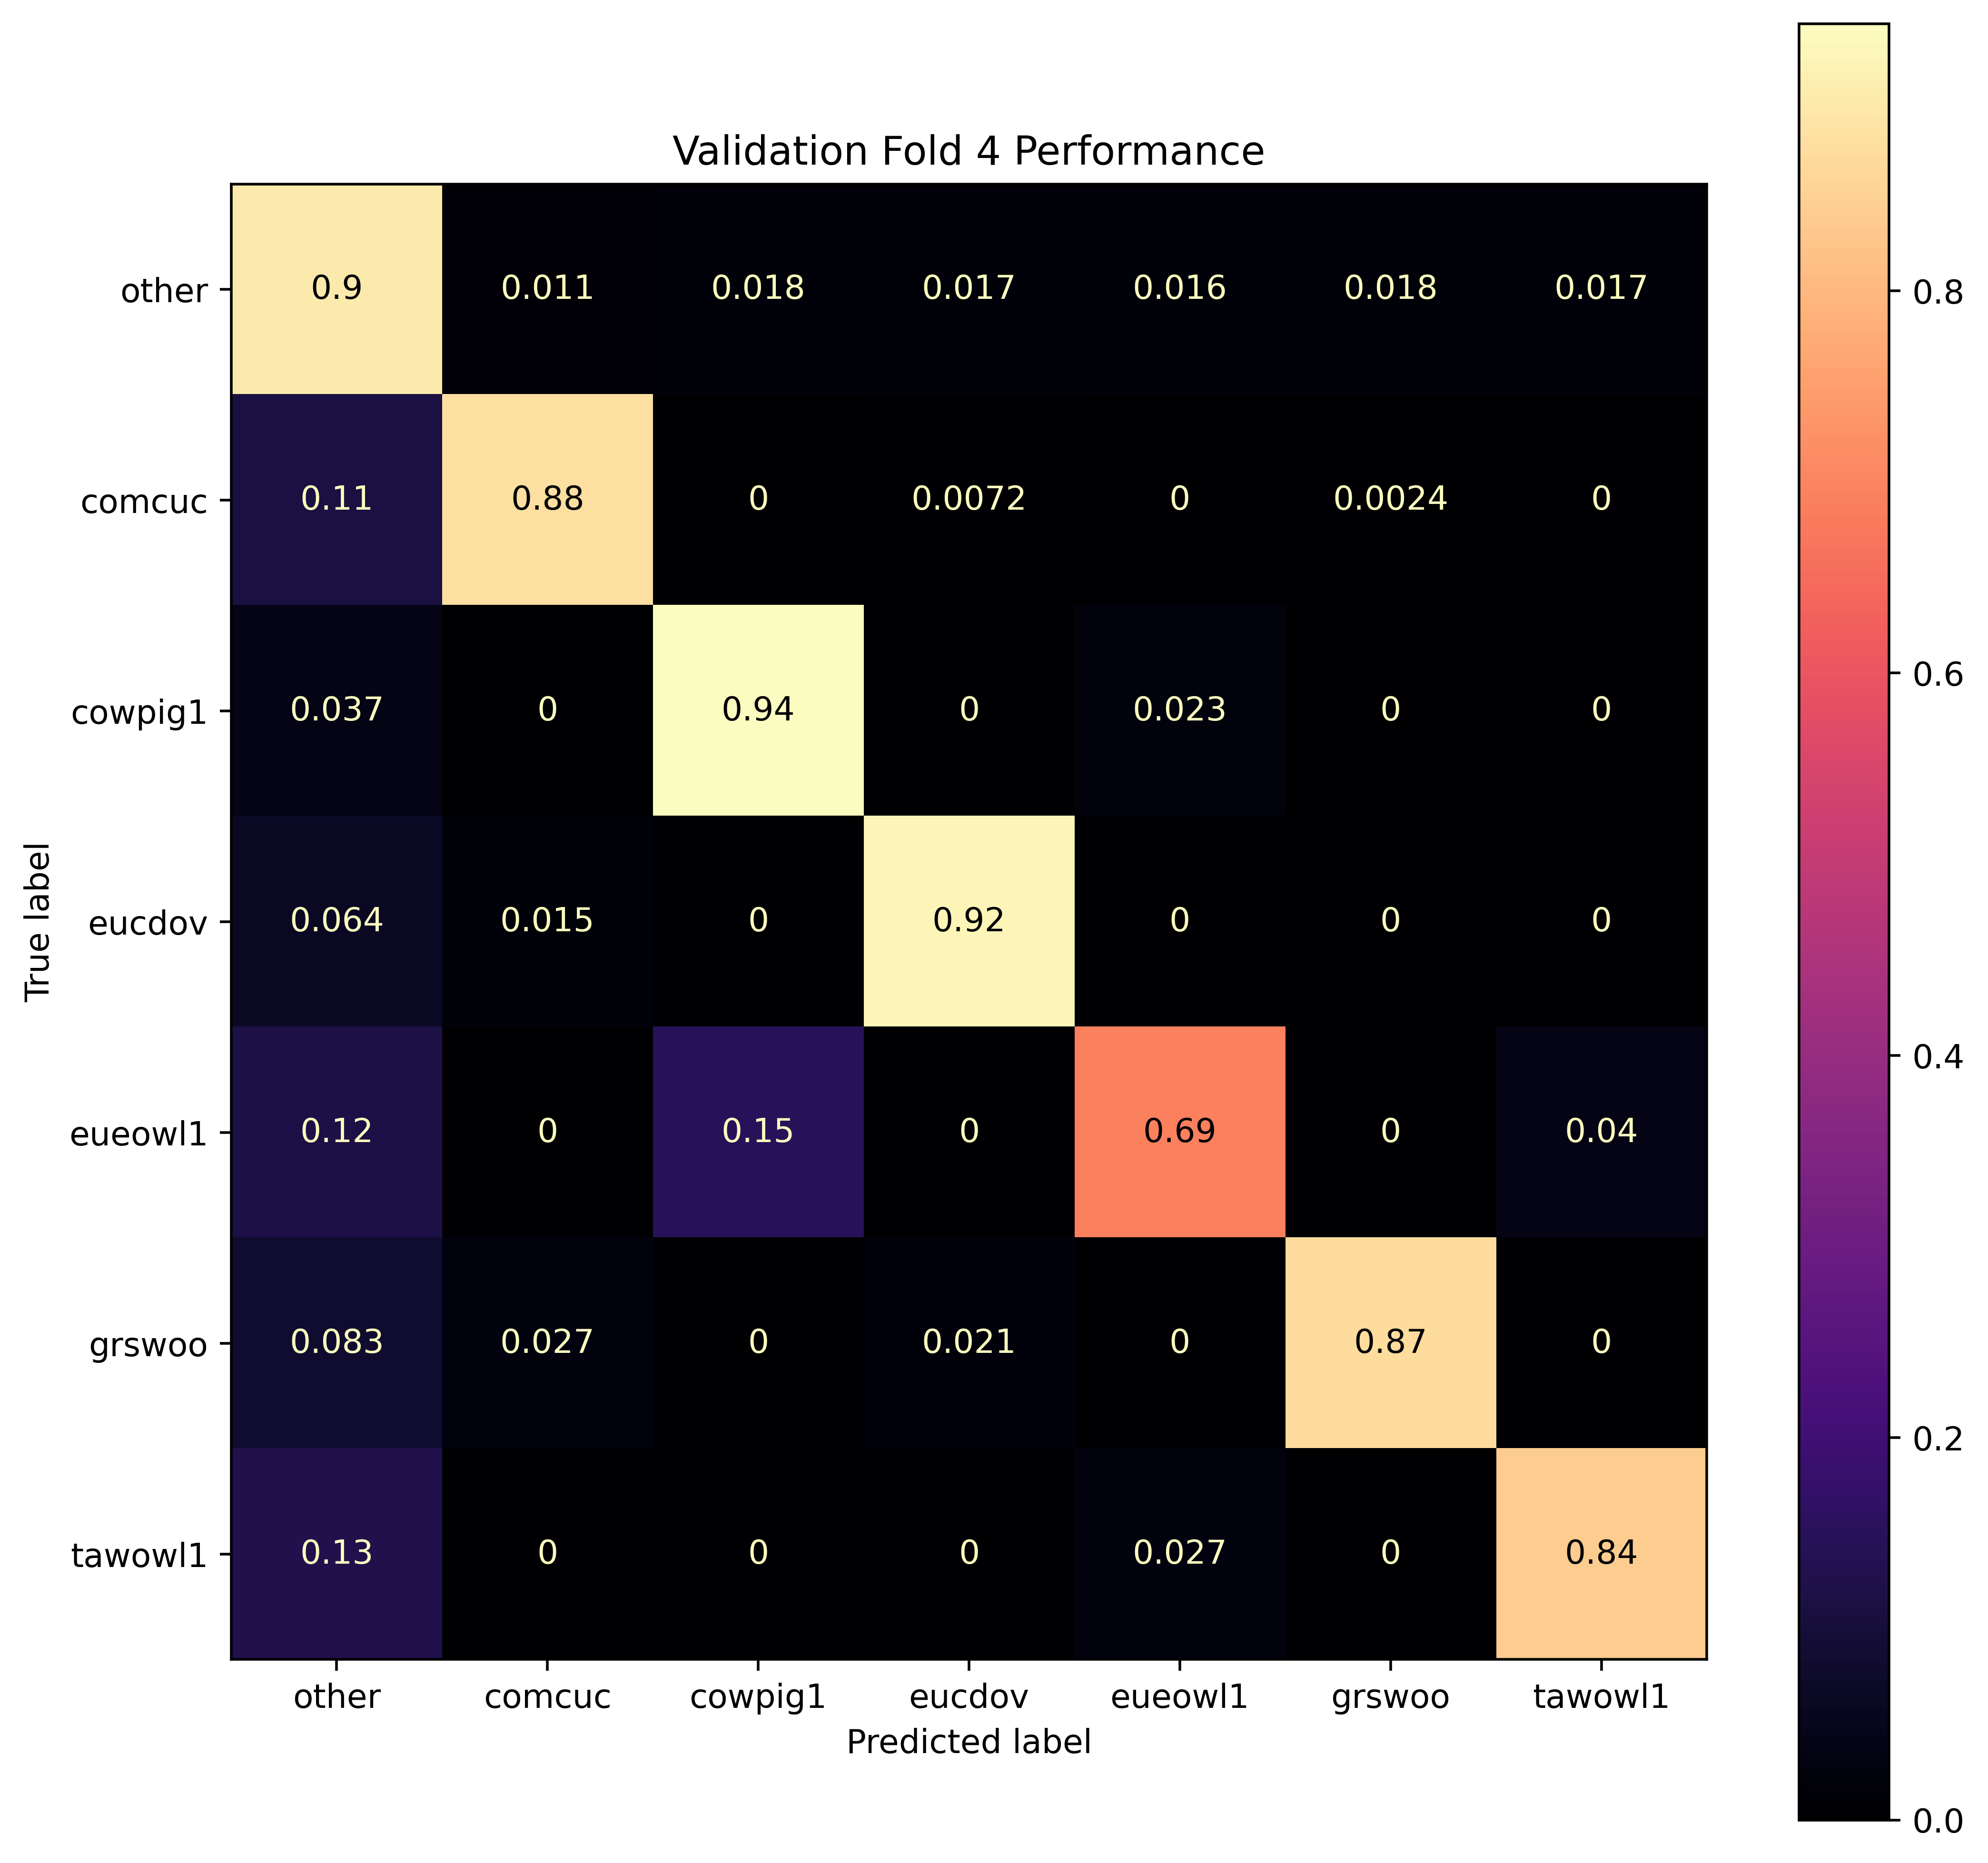

Saved model with scaler as "attention_classifier cv2023-05-17_20.02 fold-4"
Training fold 5
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.1535,  9.3891, 10.5016, 34.7896, 17.2970, 19.8349],
       device='cuda:0')
Training Epoch 0  /50 : lr = 0.01, avg_loss = 0.000509, num_samples = 86400, num_correct = 14218, acc = 0.164560, bacc = 0.251312
Evaluation Epoch 0  /50 : avg_loss = 0.000477, num_samples =  9600, num_correct =  2779, acc = 0.289479, bacc = 0.466492
Training Epoch 1  /50 : lr = 0.01, avg_loss = 0.000275, num_samples = 86400, num_correct = 32143, acc = 0.372025, bacc = 0.668607
Evaluation Epoch 1  /50 : avg_loss = 0.000338, num_samples =  9600, num_correct =  4348, acc = 0.452917, bacc = 0.688447
Training Epoch 2  /50 : lr = 0.01, avg_loss = 0.000210, num_samples = 86400, num_correct = 46752, acc = 0.541111, bacc = 0.758988
Evaluation Epoch 2  /50 : avg_loss = 0.000235, num_samples =  9600, num_correct =  6202, acc = 0.646042, bacc = 0.7

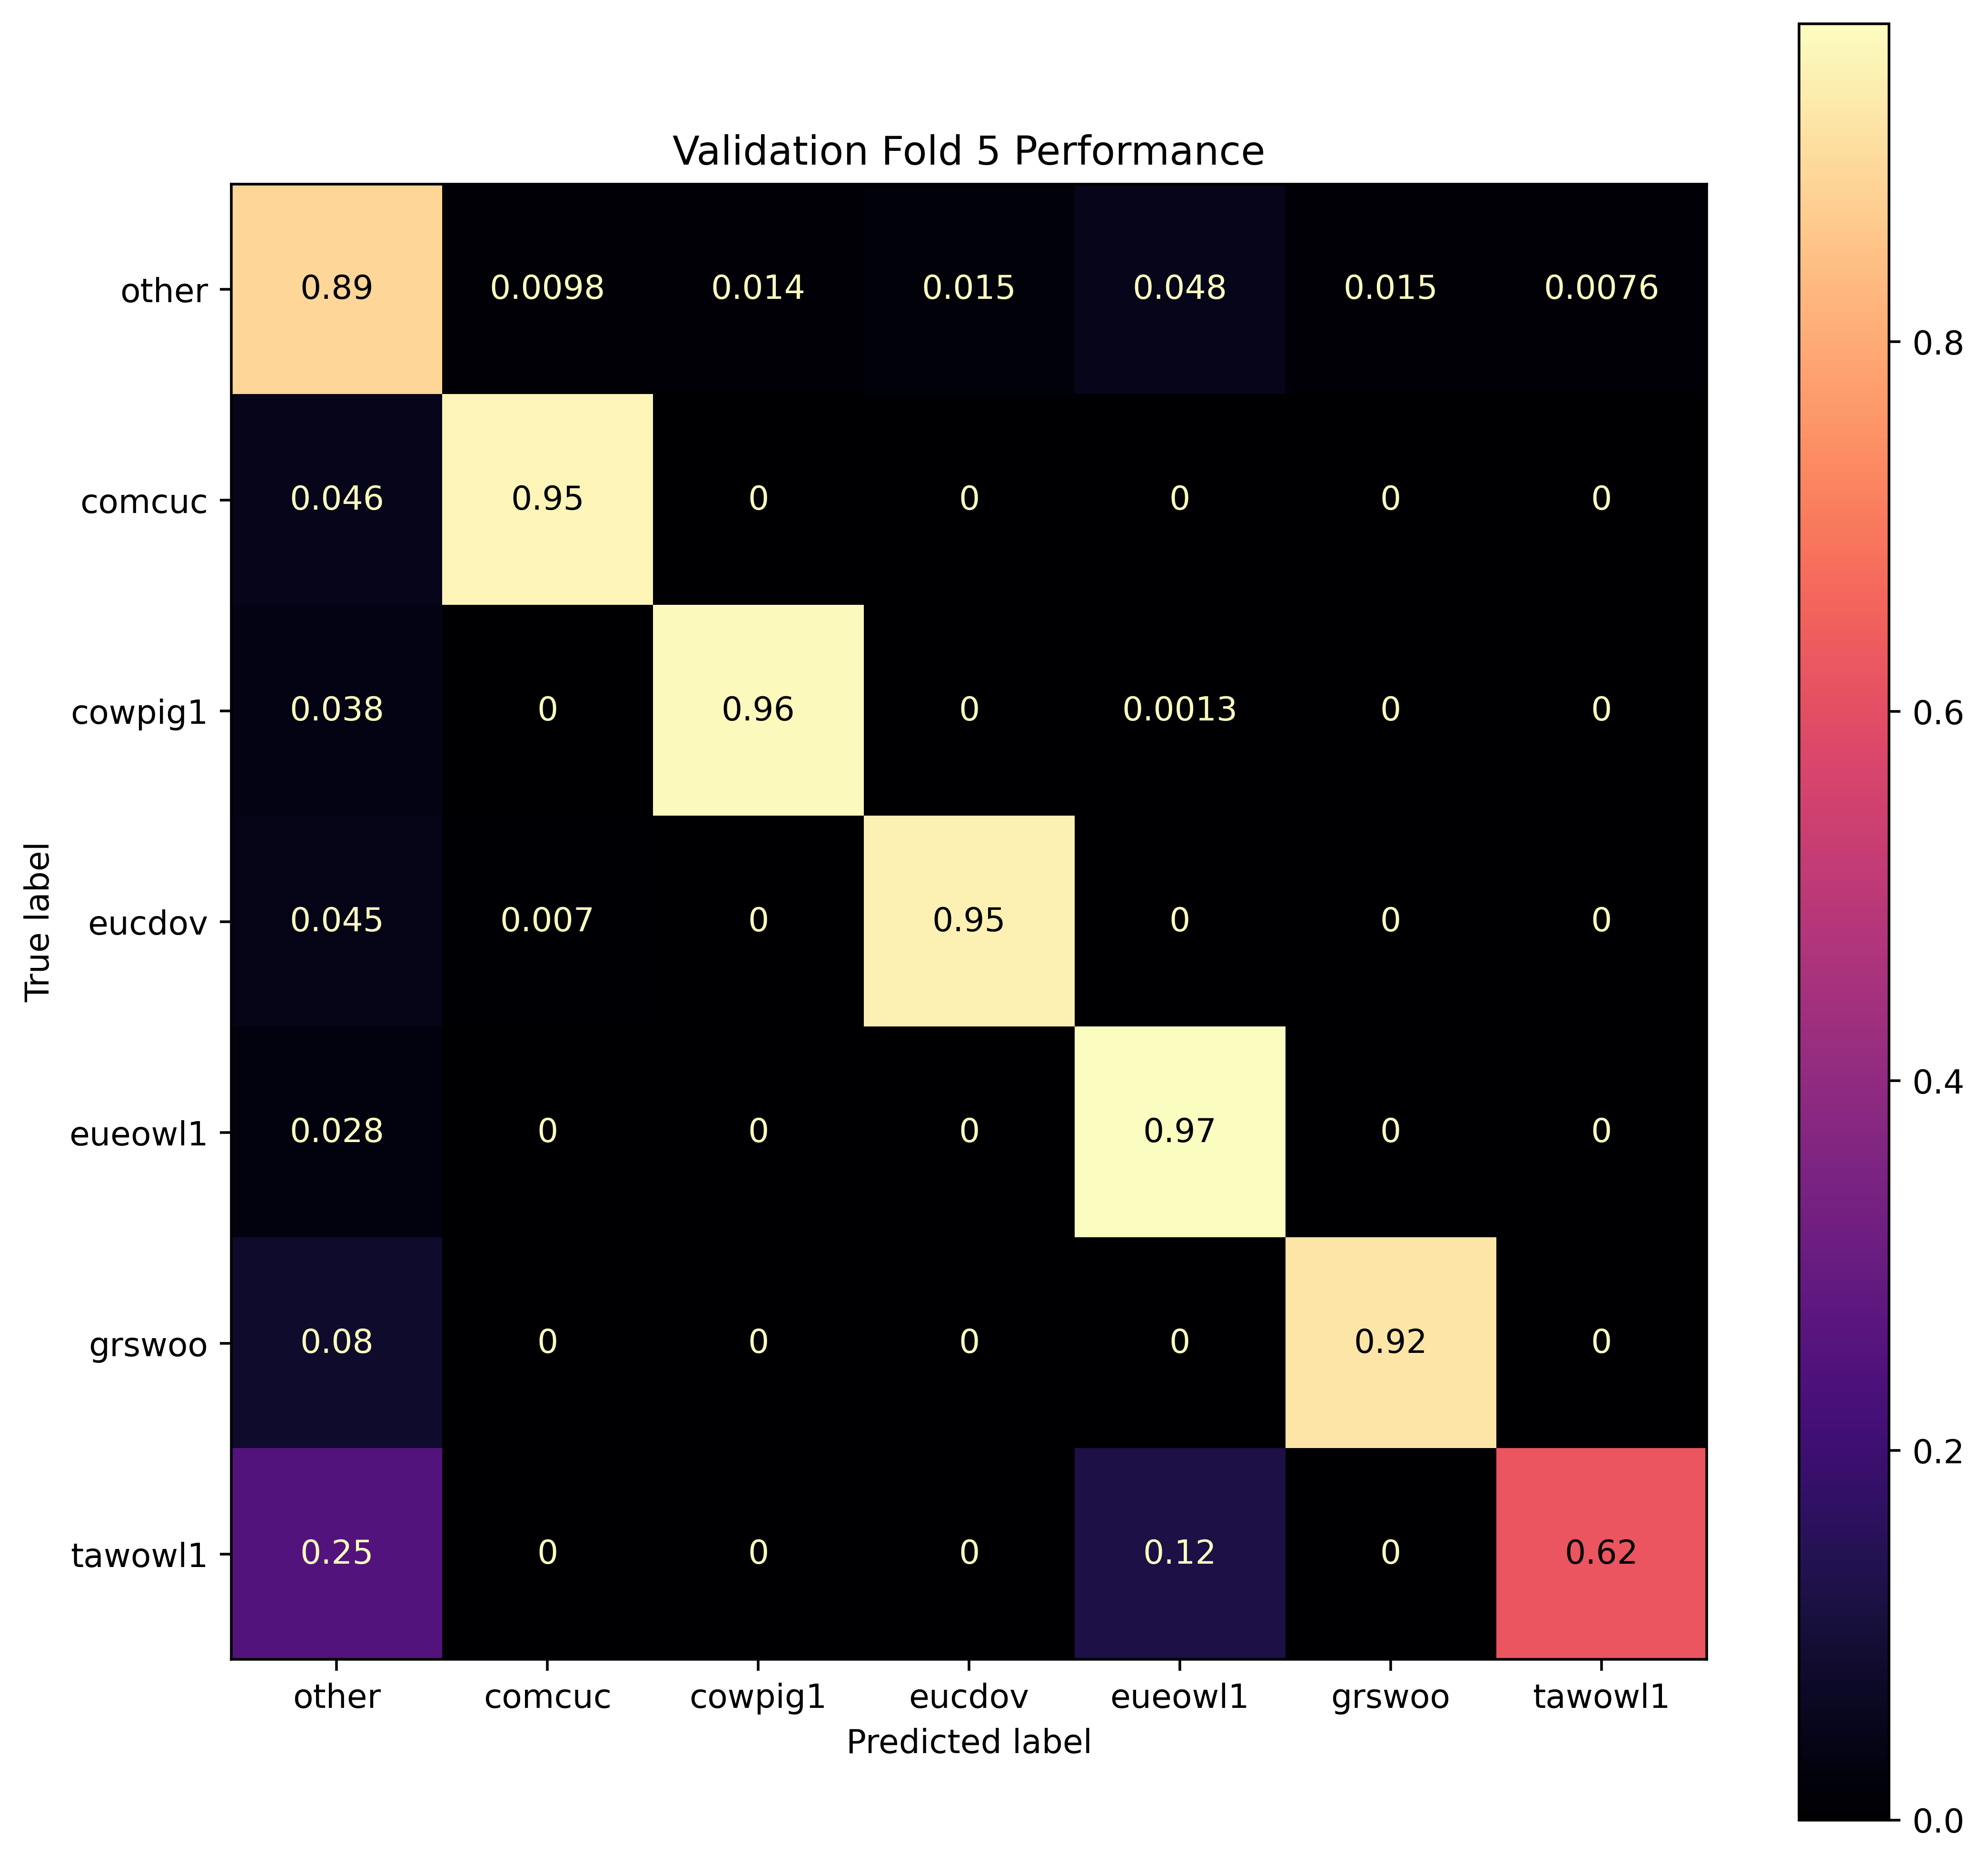

Saved model with scaler as "attention_classifier cv2023-05-17_20.02 fold-5"
Training fold 6
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.5322,  9.7103, 10.4657, 37.7940, 18.6807, 19.9229],
       device='cuda:0')
Training Epoch 0  /50 : lr = 0.01, avg_loss = 0.000497, num_samples = 86400, num_correct =  8112, acc = 0.093889, bacc = 0.213553
Evaluation Epoch 0  /50 : avg_loss = 0.000459, num_samples =  9600, num_correct =  2187, acc = 0.227813, bacc = 0.381355
Training Epoch 1  /50 : lr = 0.01, avg_loss = 0.000324, num_samples = 86400, num_correct = 17832, acc = 0.206389, bacc = 0.542630
Evaluation Epoch 1  /50 : avg_loss = 0.000448, num_samples =  9600, num_correct =  2579, acc = 0.268646, bacc = 0.697551
Training Epoch 2  /50 : lr = 0.01, avg_loss = 0.000230, num_samples = 86400, num_correct = 26656, acc = 0.308519, bacc = 0.728324
Evaluation Epoch 2  /50 : avg_loss = 0.000334, num_samples =  9600, num_correct =  4960, acc = 0.516667, bacc = 0.8

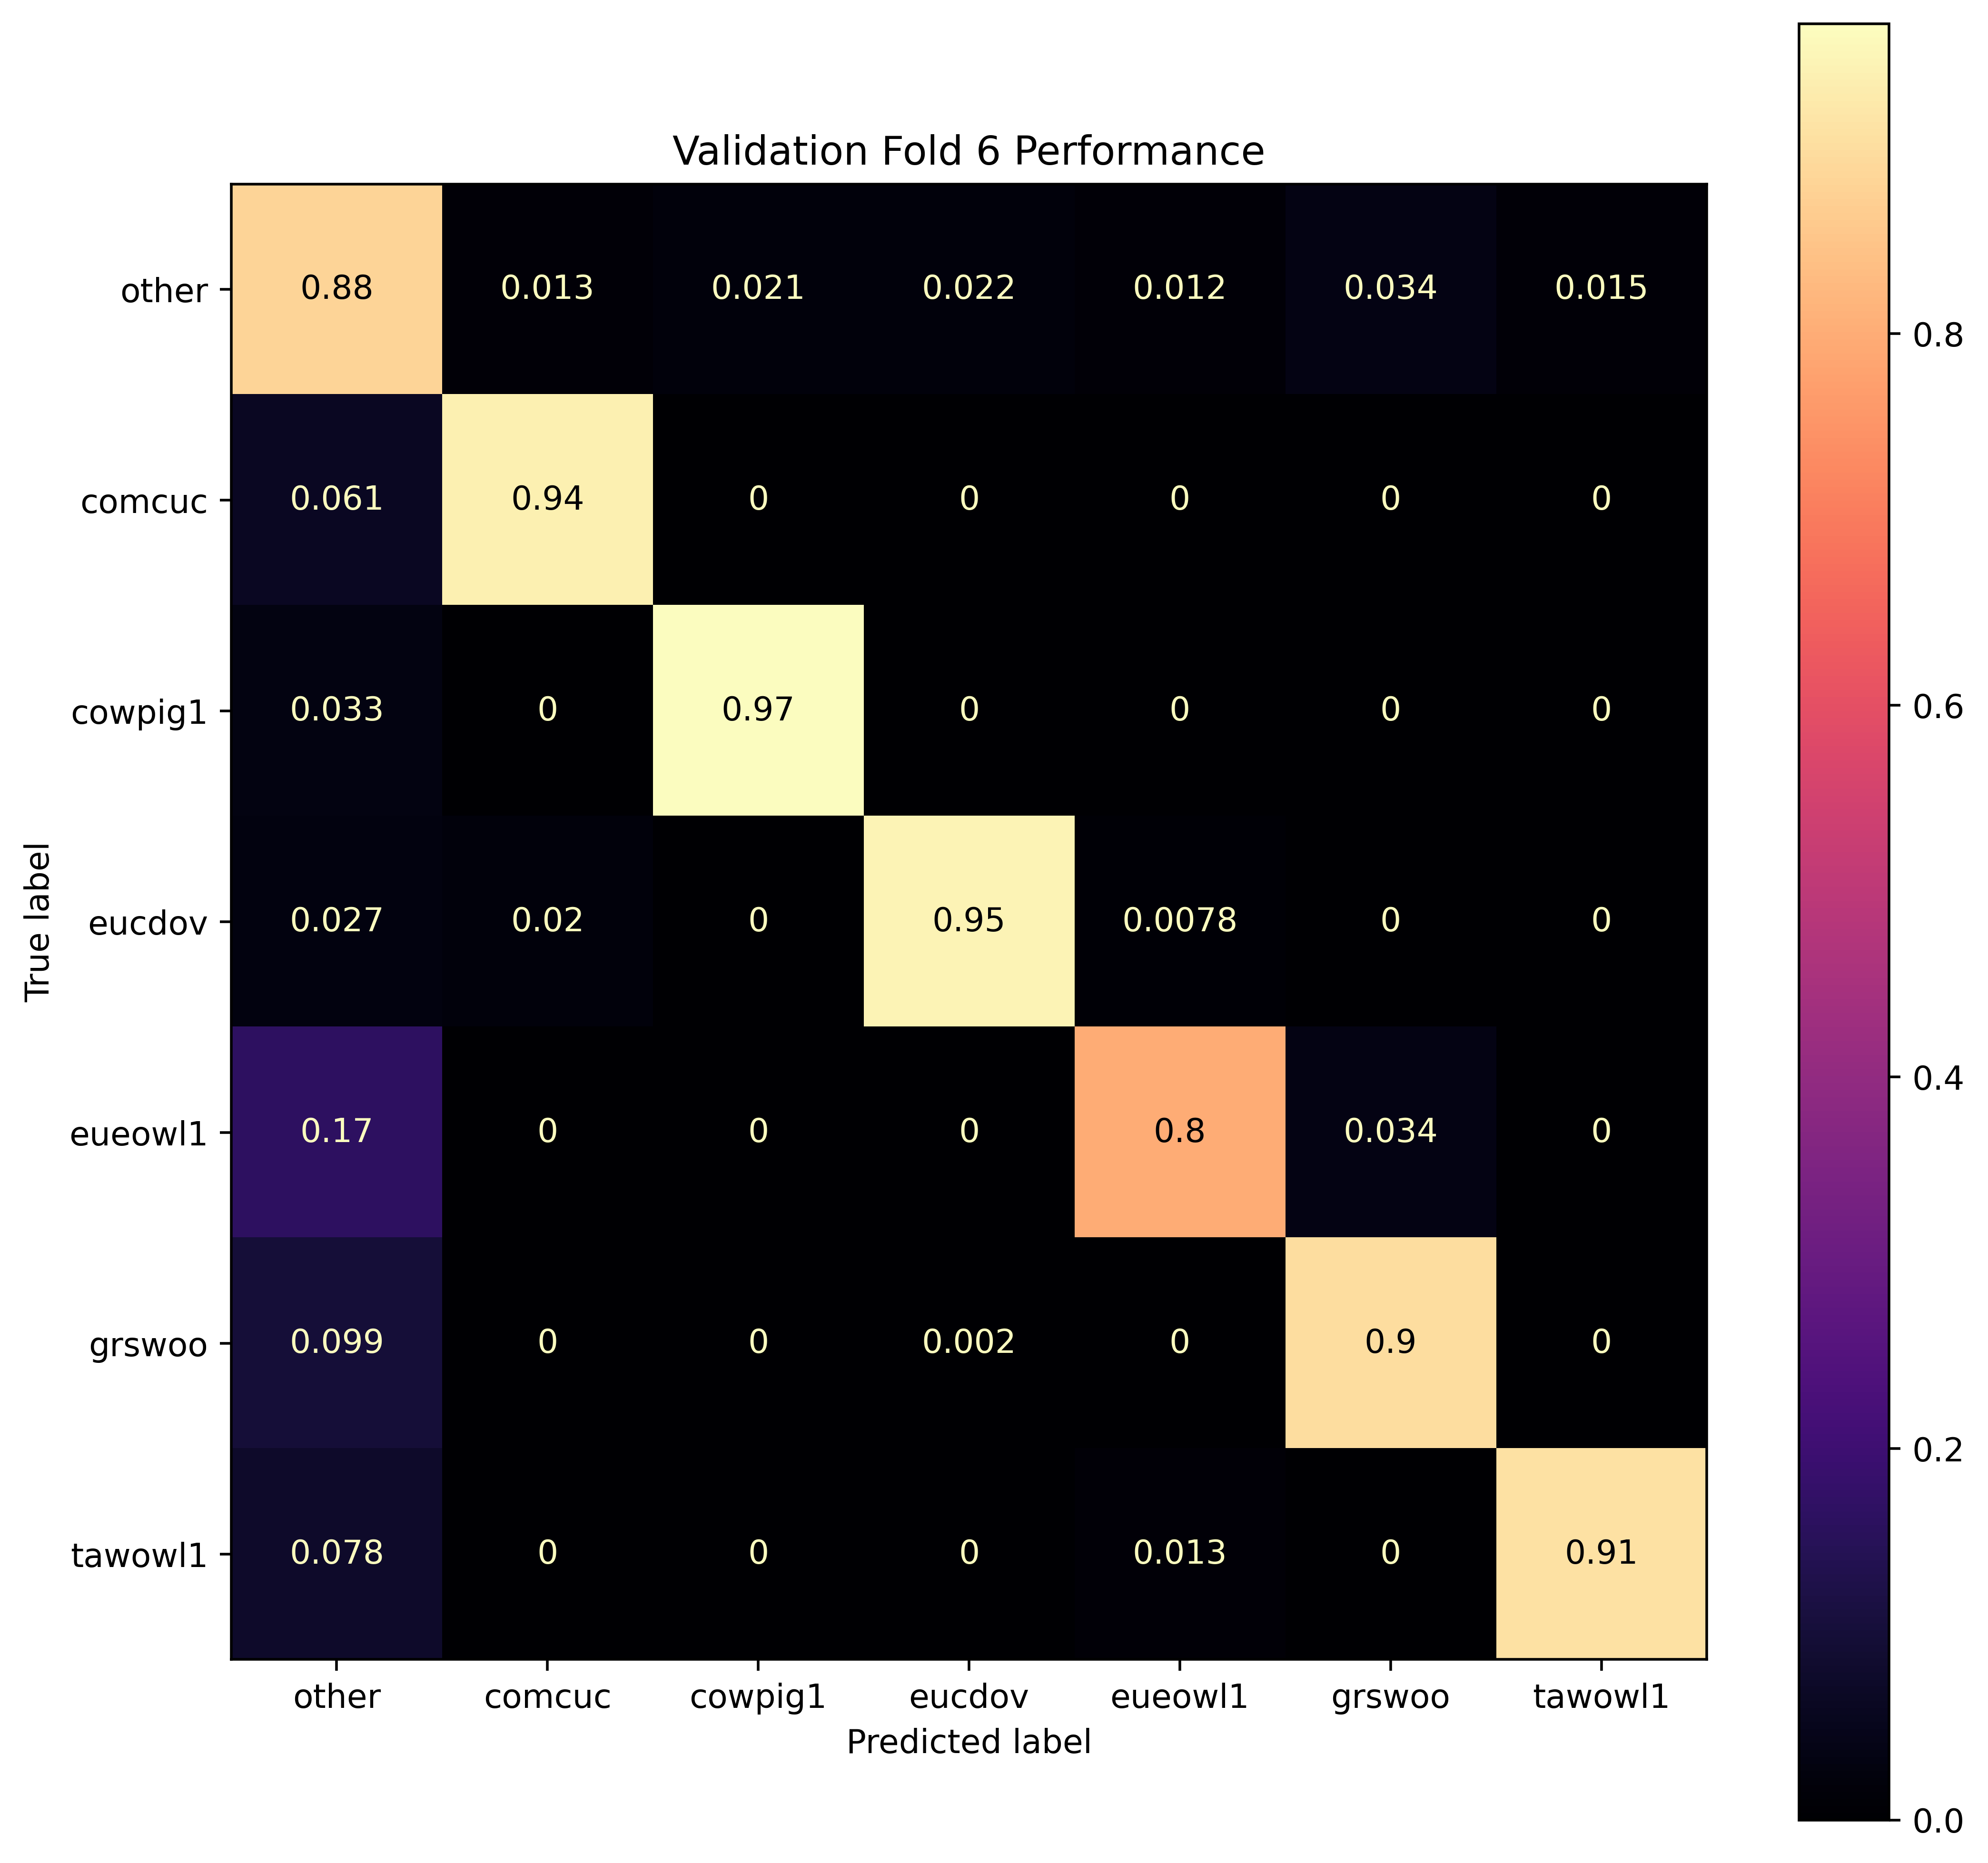

Saved model with scaler as "attention_classifier cv2023-05-17_20.02 fold-6"
Training fold 7
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.2754,  9.2280, 10.5393, 36.0422, 17.5385, 19.9870],
       device='cuda:0')
Training Epoch 0  /50 : lr = 0.01, avg_loss = 0.000514, num_samples = 86400, num_correct = 11203, acc = 0.129664, bacc = 0.255359
Evaluation Epoch 0  /50 : avg_loss = 0.000495, num_samples =  9600, num_correct =  1988, acc = 0.207083, bacc = 0.581139
Training Epoch 1  /50 : lr = 0.01, avg_loss = 0.000294, num_samples = 86400, num_correct = 21169, acc = 0.245012, bacc = 0.616398
Evaluation Epoch 1  /50 : avg_loss = 0.000490, num_samples =  9600, num_correct =  2598, acc = 0.270625, bacc = 0.698697
Training Epoch 2  /50 : lr = 0.01, avg_loss = 0.000219, num_samples = 86400, num_correct = 32045, acc = 0.370891, bacc = 0.741620
Evaluation Epoch 2  /50 : avg_loss = 0.000441, num_samples =  9600, num_correct =  4518, acc = 0.470625, bacc = 0.7

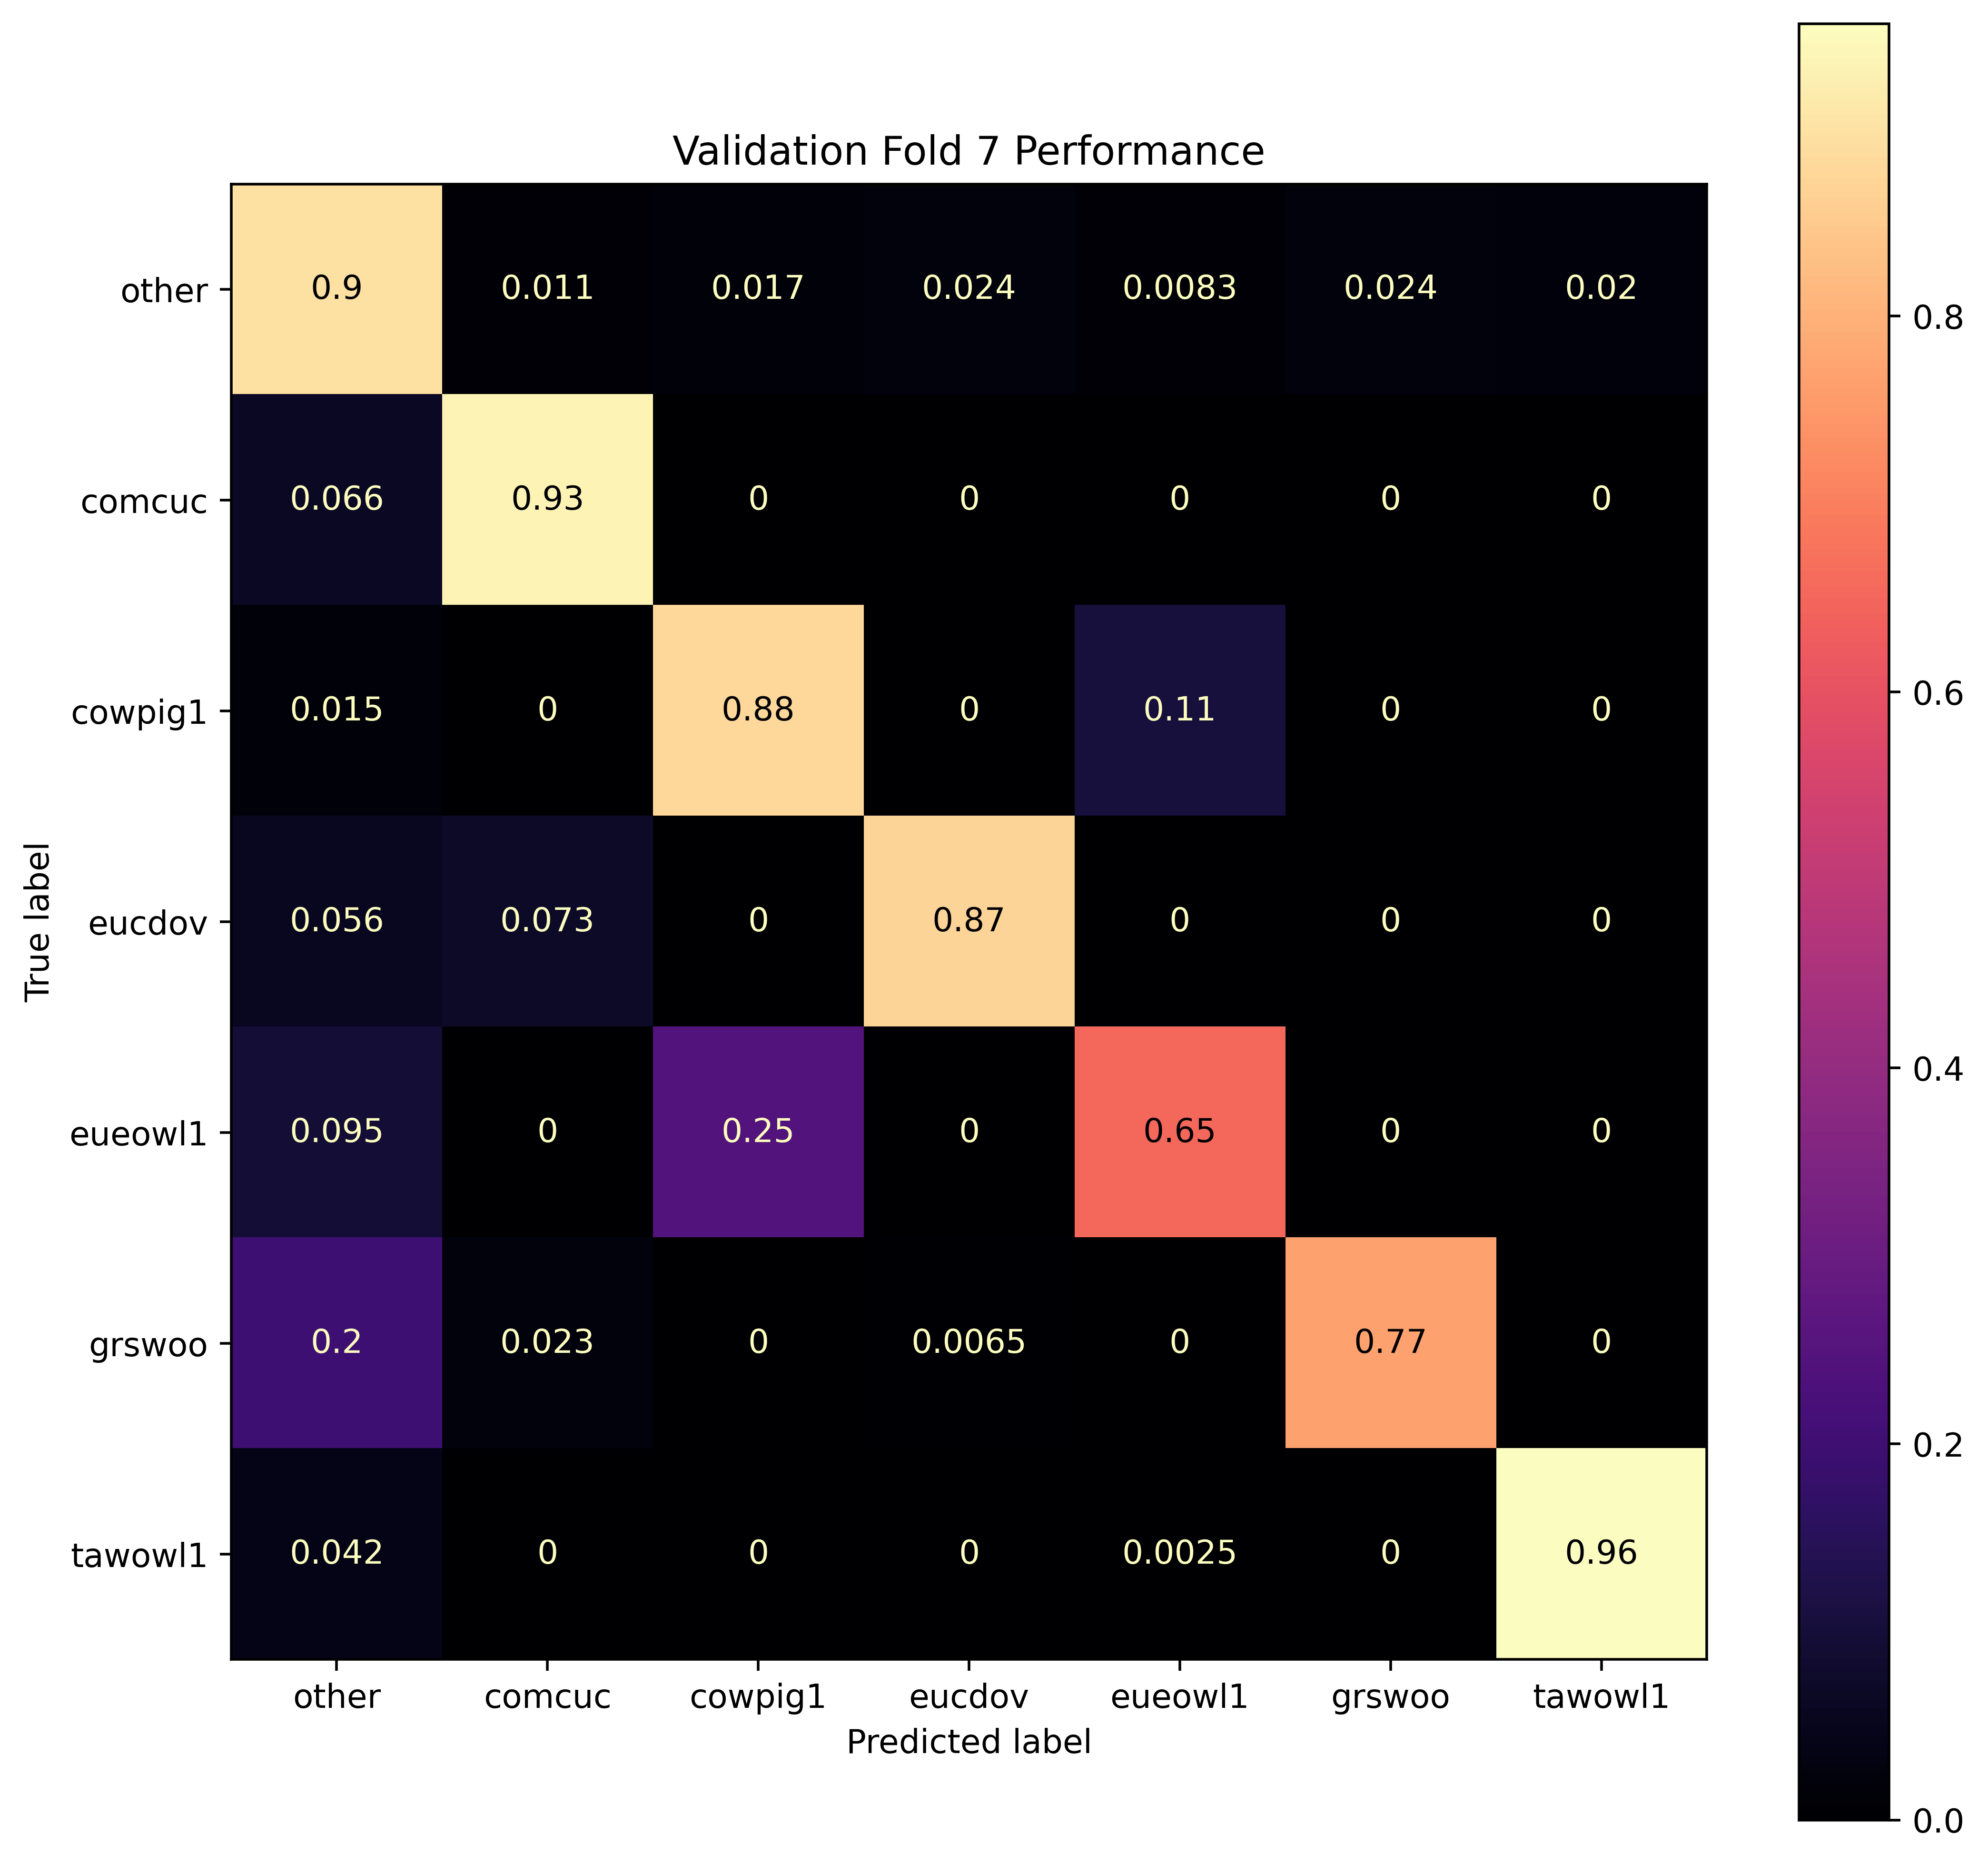

Saved model with scaler as "attention_classifier cv2023-05-17_20.02 fold-7"
Training fold 8
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 14.8754,  9.0629, 10.1272, 34.8762, 17.6241, 19.4274],
       device='cuda:0')
Training Epoch 0  /50 : lr = 0.01, avg_loss = 0.000514, num_samples = 86400, num_correct = 10881, acc = 0.125938, bacc = 0.251247
Evaluation Epoch 0  /50 : avg_loss = 0.000515, num_samples =  9600, num_correct =  1529, acc = 0.159271, bacc = 0.554485
Training Epoch 1  /50 : lr = 0.01, avg_loss = 0.000293, num_samples = 86400, num_correct = 21013, acc = 0.243206, bacc = 0.630078
Evaluation Epoch 1  /50 : avg_loss = 0.000429, num_samples =  9600, num_correct =  2823, acc = 0.294063, bacc = 0.797544
Training Epoch 2  /50 : lr = 0.01, avg_loss = 0.000187, num_samples = 86400, num_correct = 44815, acc = 0.518692, bacc = 0.784985
Evaluation Epoch 2  /50 : avg_loss = 0.000264, num_samples =  9600, num_correct =  6169, acc = 0.642604, bacc = 0.8

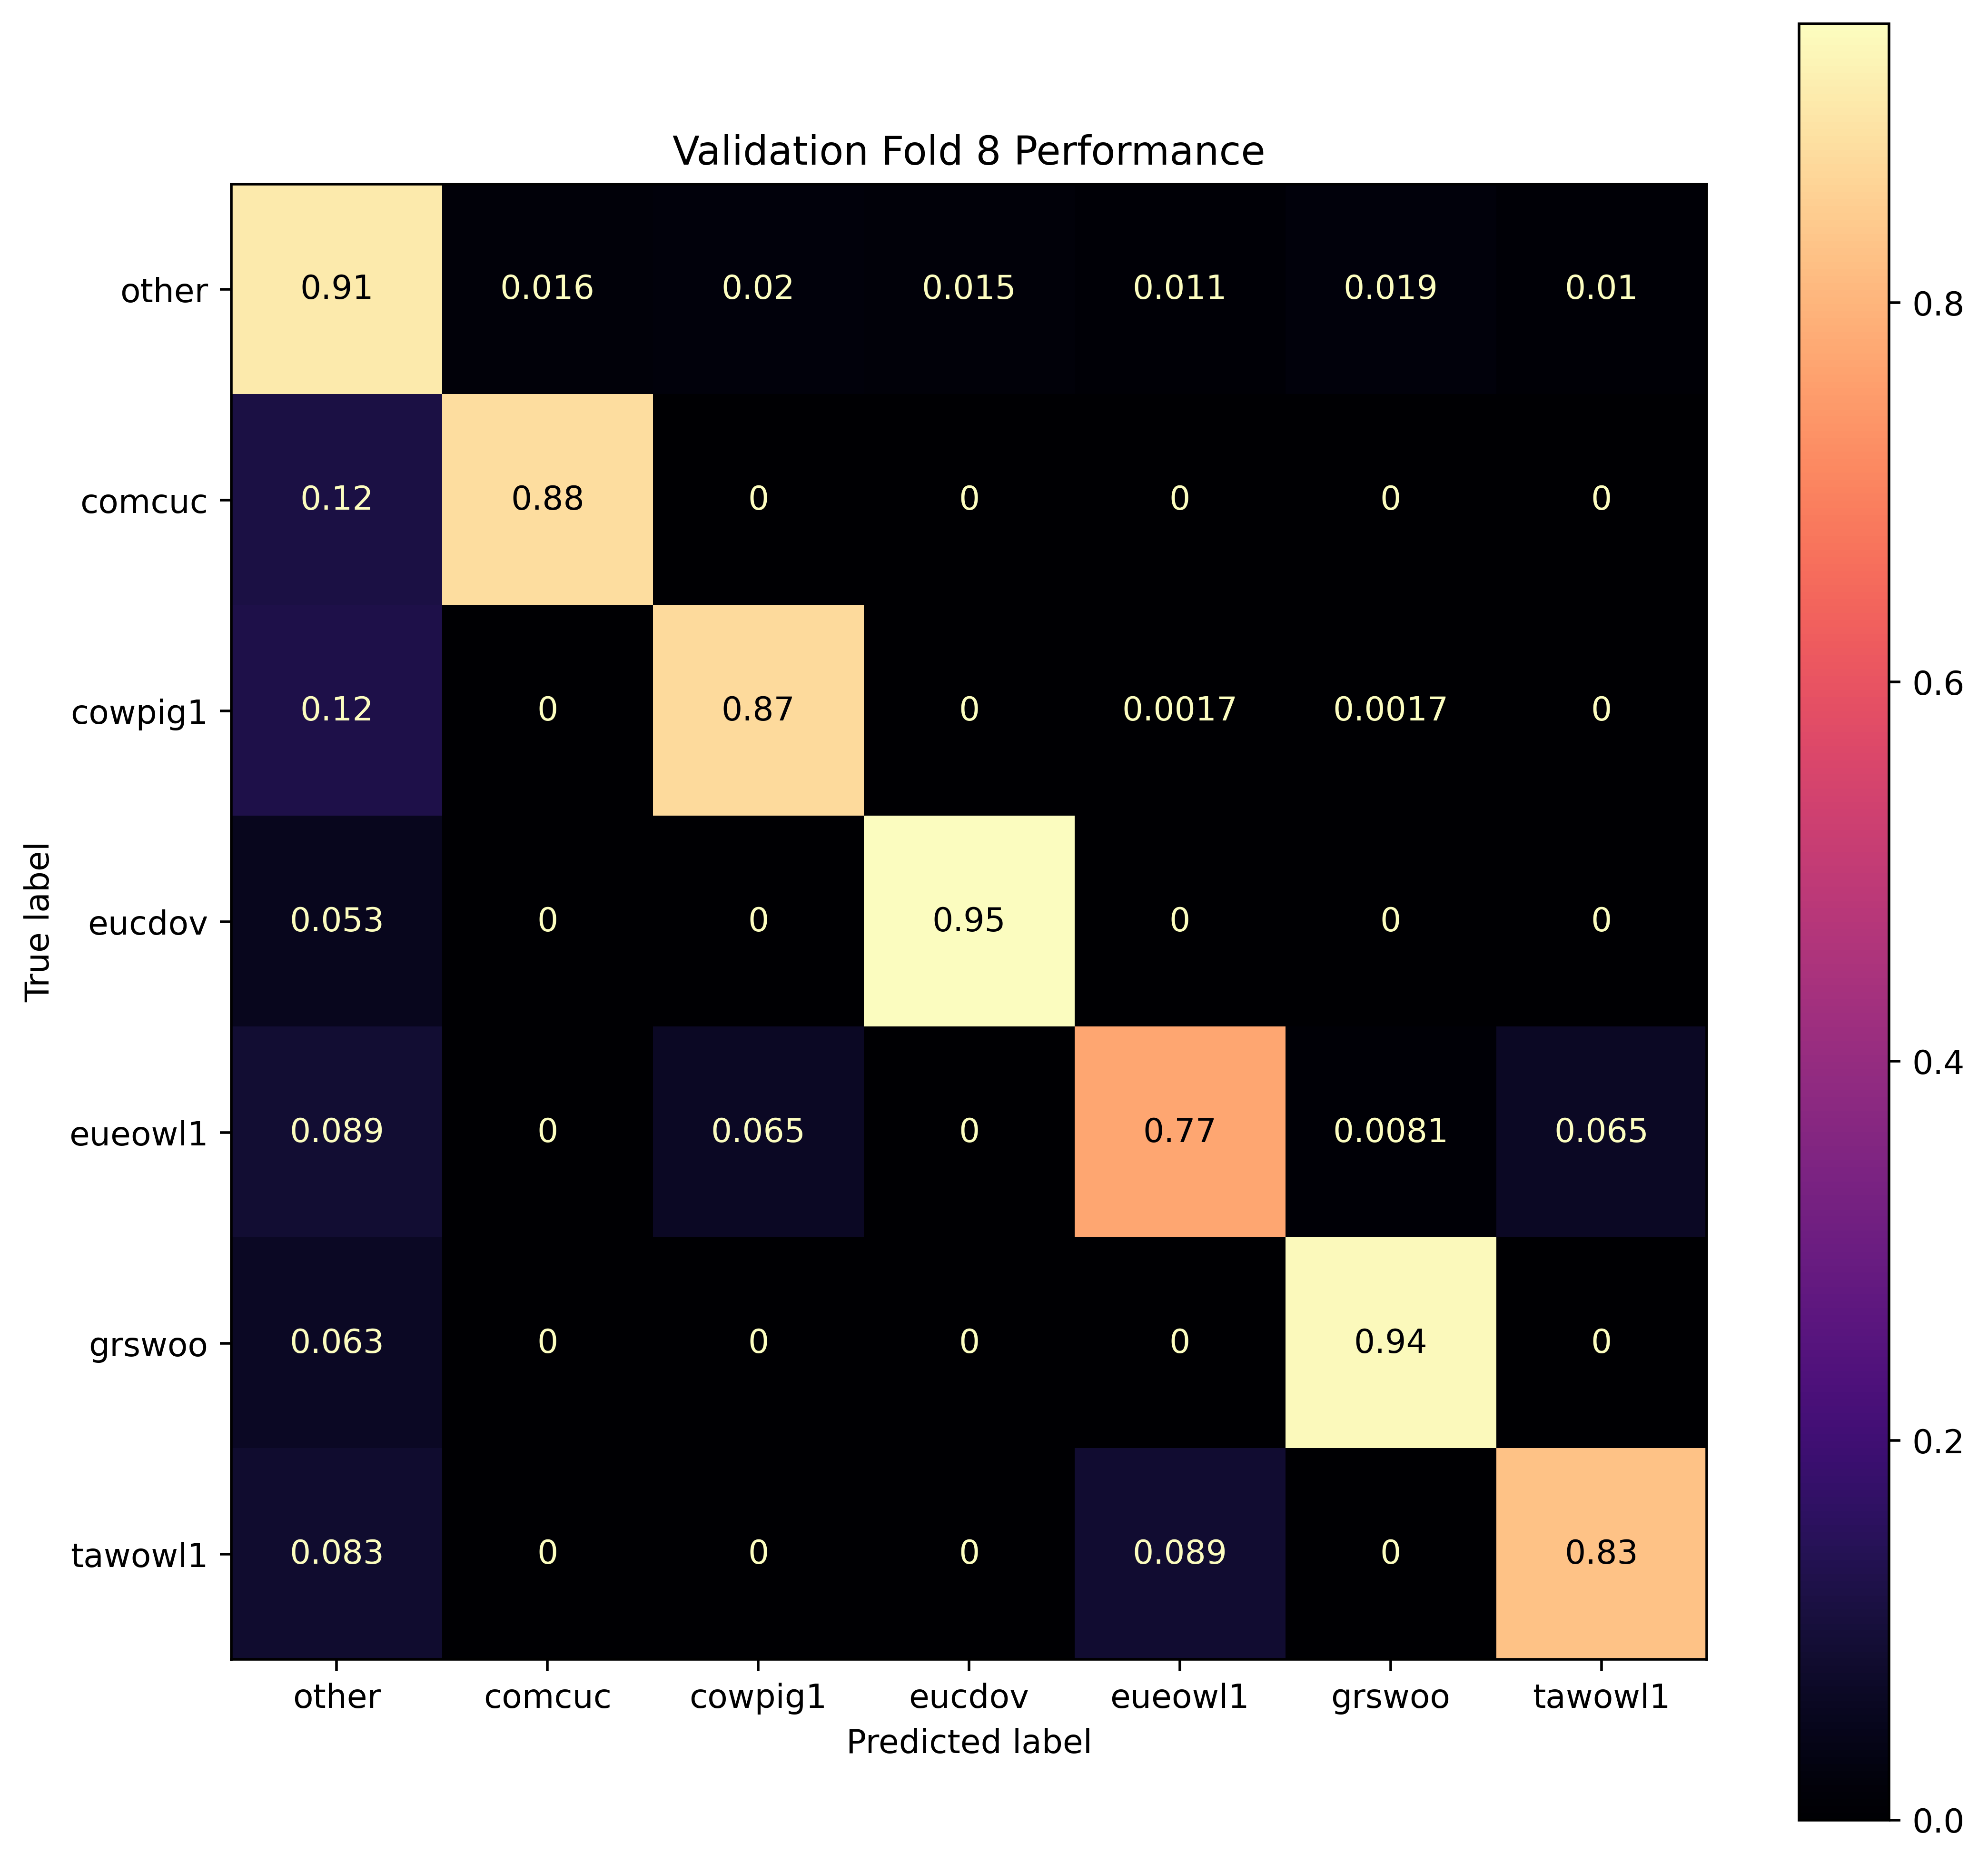

Saved model with scaler as "attention_classifier cv2023-05-17_20.02 fold-8"
Training fold 9
Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.2223,  9.4648, 10.3051, 37.4453, 18.2622, 19.2489],
       device='cuda:0')
Training Epoch 0  /50 : lr = 0.01, avg_loss = 0.000504, num_samples = 86400, num_correct = 12039, acc = 0.139340, bacc = 0.269906
Evaluation Epoch 0  /50 : avg_loss = 0.000439, num_samples =  9600, num_correct =  3068, acc = 0.319583, bacc = 0.498512
Training Epoch 1  /50 : lr = 0.01, avg_loss = 0.000330, num_samples = 86400, num_correct = 24509, acc = 0.283669, bacc = 0.543219
Evaluation Epoch 1  /50 : avg_loss = 0.000320, num_samples =  9600, num_correct =  4545, acc = 0.473438, bacc = 0.649824
Training Epoch 2  /50 : lr = 0.01, avg_loss = 0.000228, num_samples = 86400, num_correct = 34153, acc = 0.395289, bacc = 0.705871
Evaluation Epoch 2  /50 : avg_loss = 0.000318, num_samples =  9600, num_correct =  5287, acc = 0.550729, bacc = 0.7

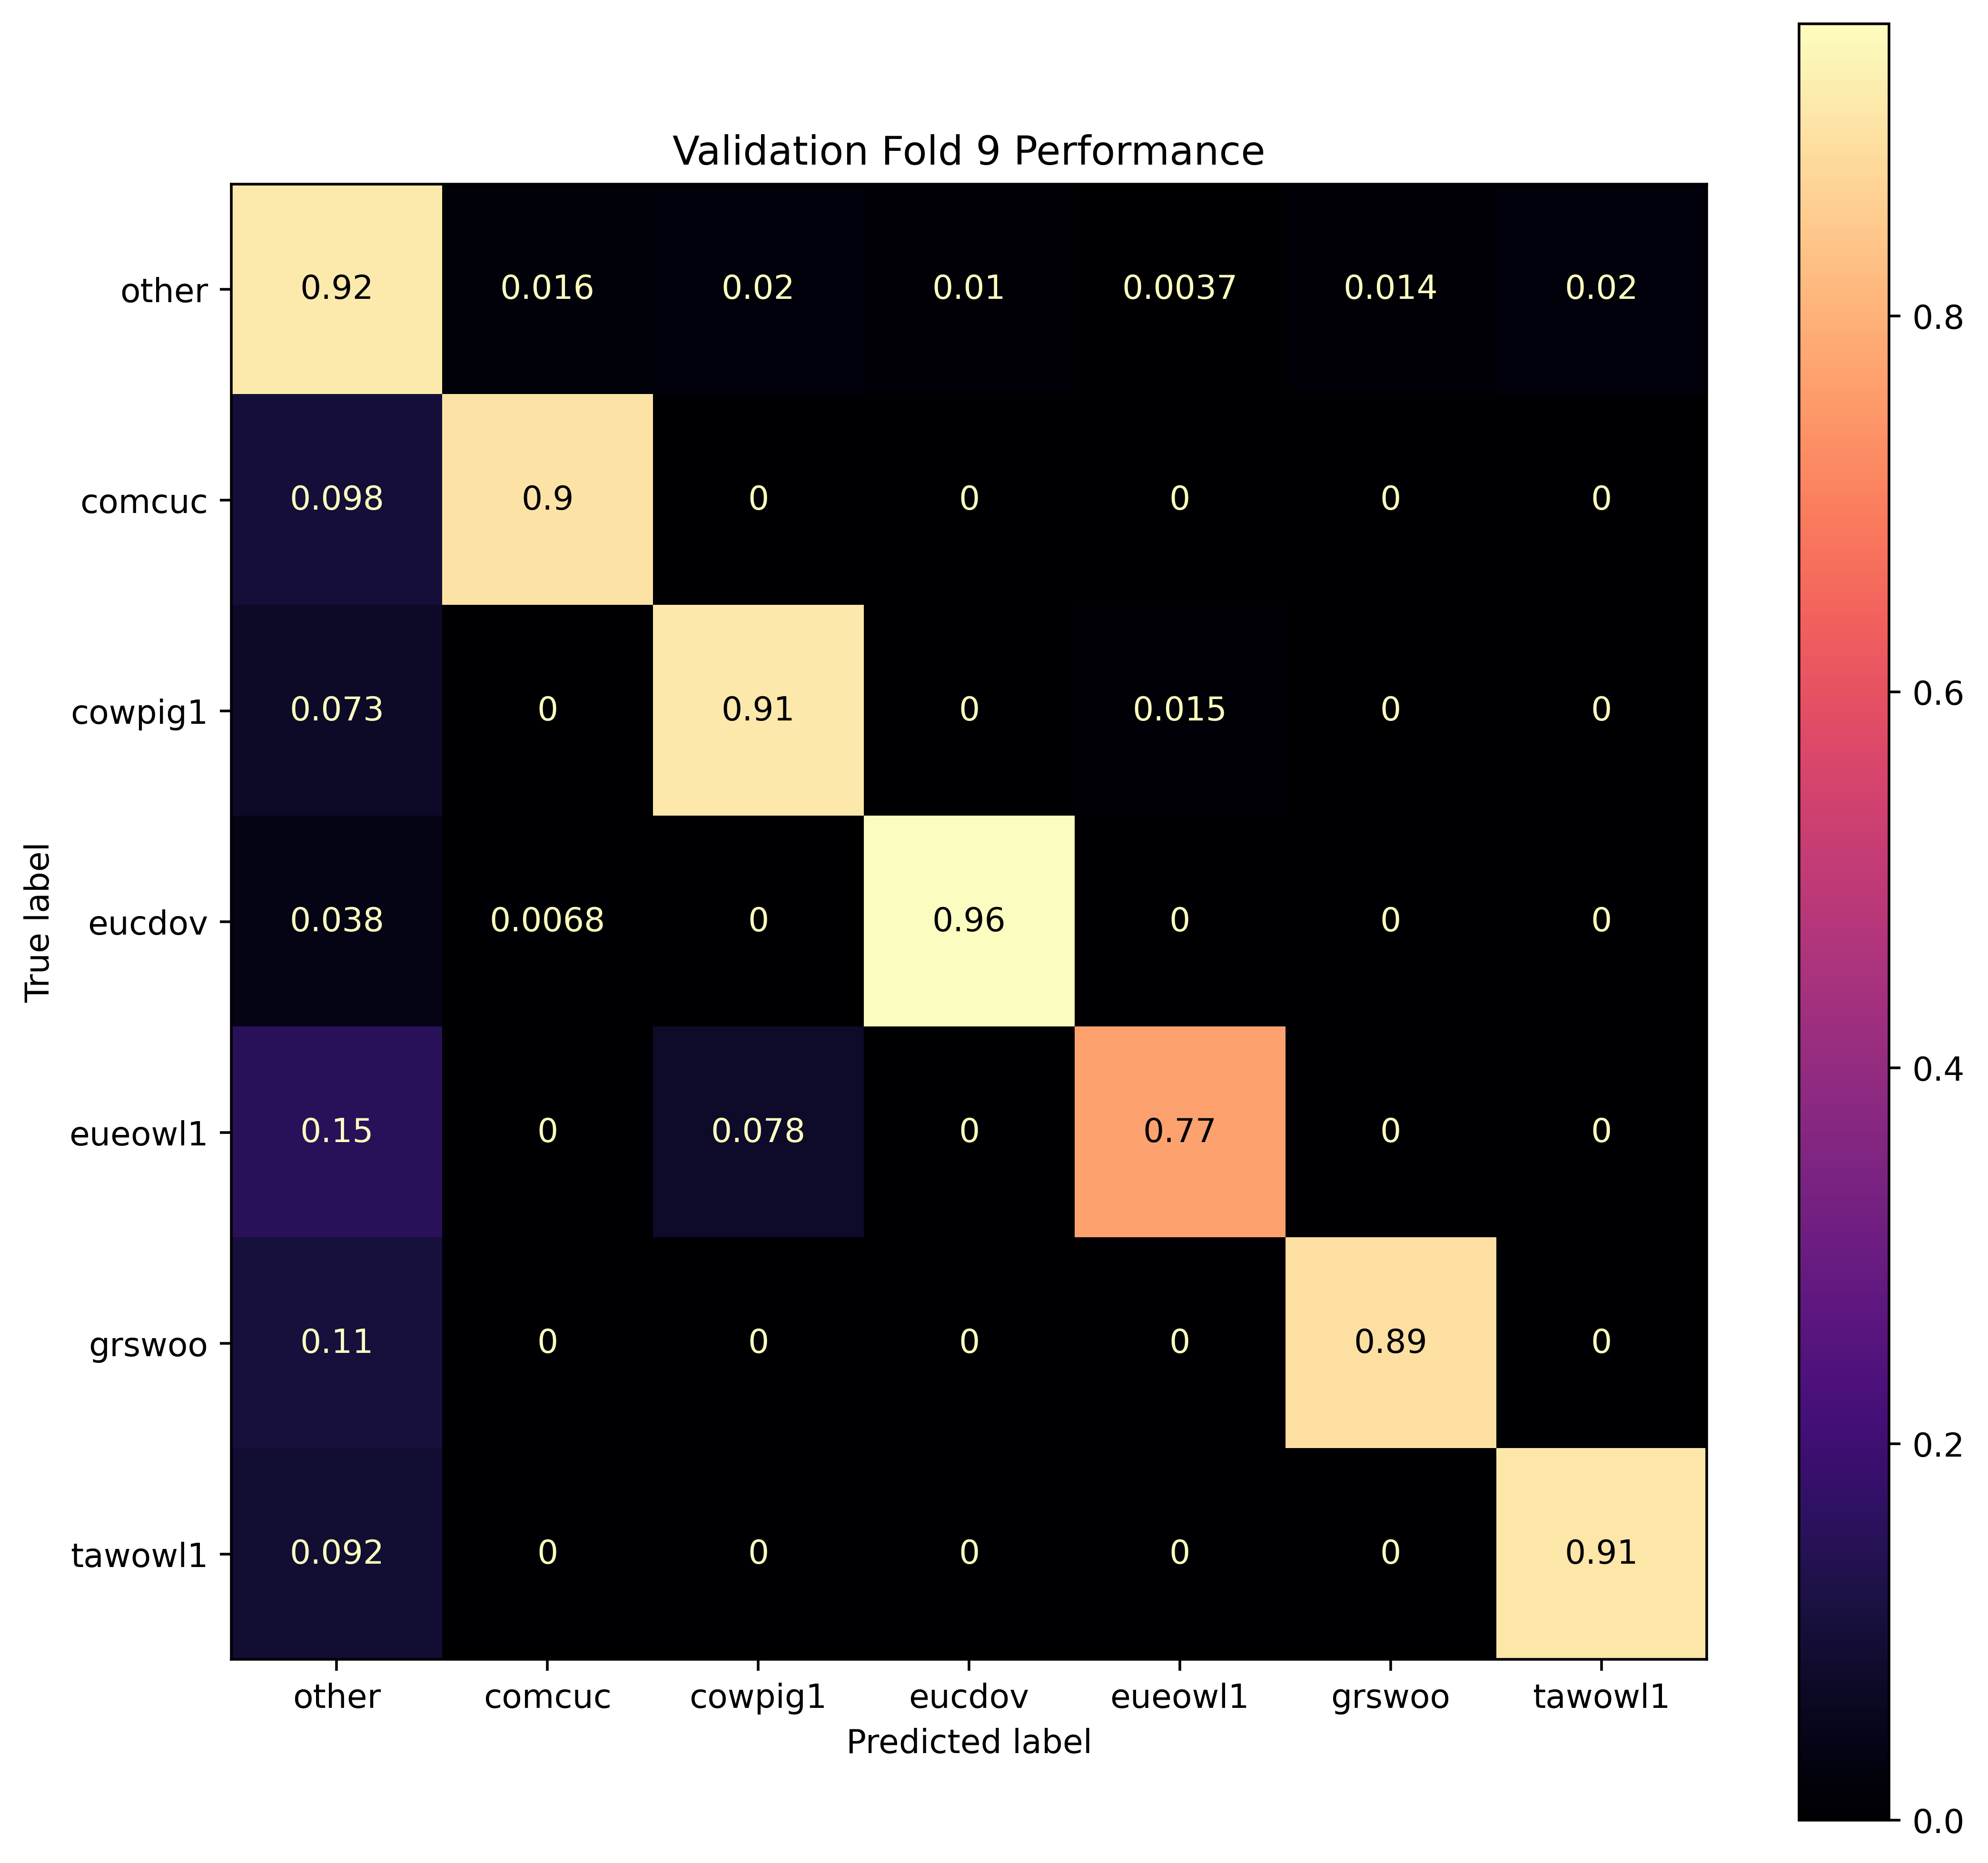

Saved model with scaler as "attention_classifier cv2023-05-17_20.02 fold-9"
avg_train_metrics      = avg_loss = 0.000017, num_samples = 86400, num_correct = 80906.600000, acc = 0.936419, bacc = 0.985239
avg_evaluation_metrics = avg_loss = 0.015265, num_samples =  9600, num_correct = 8526.200000, acc = 0.888146, bacc = 0.874771


In [46]:
set_random_seed(42)

cv_models_with_scalers, cv_folds_metrics = train_attention_classifier_with_cv(
    hyper_parameters, 
    training_hyper_parameters, 
    NumpyDataset(data_train, labels_train),
    device
)
avg_train_metrics, avg_evaluation_metrics = calculate_average_metrics_for_folds(cv_folds_metrics)
print(f'{avg_train_metrics      = }')
print(f'{avg_evaluation_metrics = }')

Training AttentionClassifier with 37011 parameters
loss_weight = tensor([ 1.0000, 15.3204,  9.3547, 10.4259, 36.4963, 17.9374, 19.6462],
       device='cuda:0')
Training Epoch   0/50 : lr = 0.01, avg_loss = 0.000699, num_samples = 96000, num_correct = 15014, acc = 0.156396, bacc = 0.229131
Evaluation Epoch   0/50 : avg_loss = 0.000628, num_samples = 24000, num_correct =  1258, acc = 0.052417, bacc = 0.124972
Training Epoch   1/50 : lr = 0.01, avg_loss = 0.000967, num_samples = 96000, num_correct = 17032, acc = 0.177417, bacc = 0.383045
Evaluation Epoch   1/50 : avg_loss = 0.001123, num_samples = 24000, num_correct =  8220, acc = 0.342500, bacc = 0.092735
Training Epoch   2/50 : lr = 0.01, avg_loss = 0.000788, num_samples = 96000, num_correct = 16207, acc = 0.168823, bacc = 0.165023
Evaluation Epoch   2/50 : avg_loss = 0.000623, num_samples = 24000, num_correct =  1196, acc = 0.049833, bacc = 0.149810
Training Epoch   3/50 : lr = 0.005, avg_loss = 0.000616, num_samples = 96000, num_corr

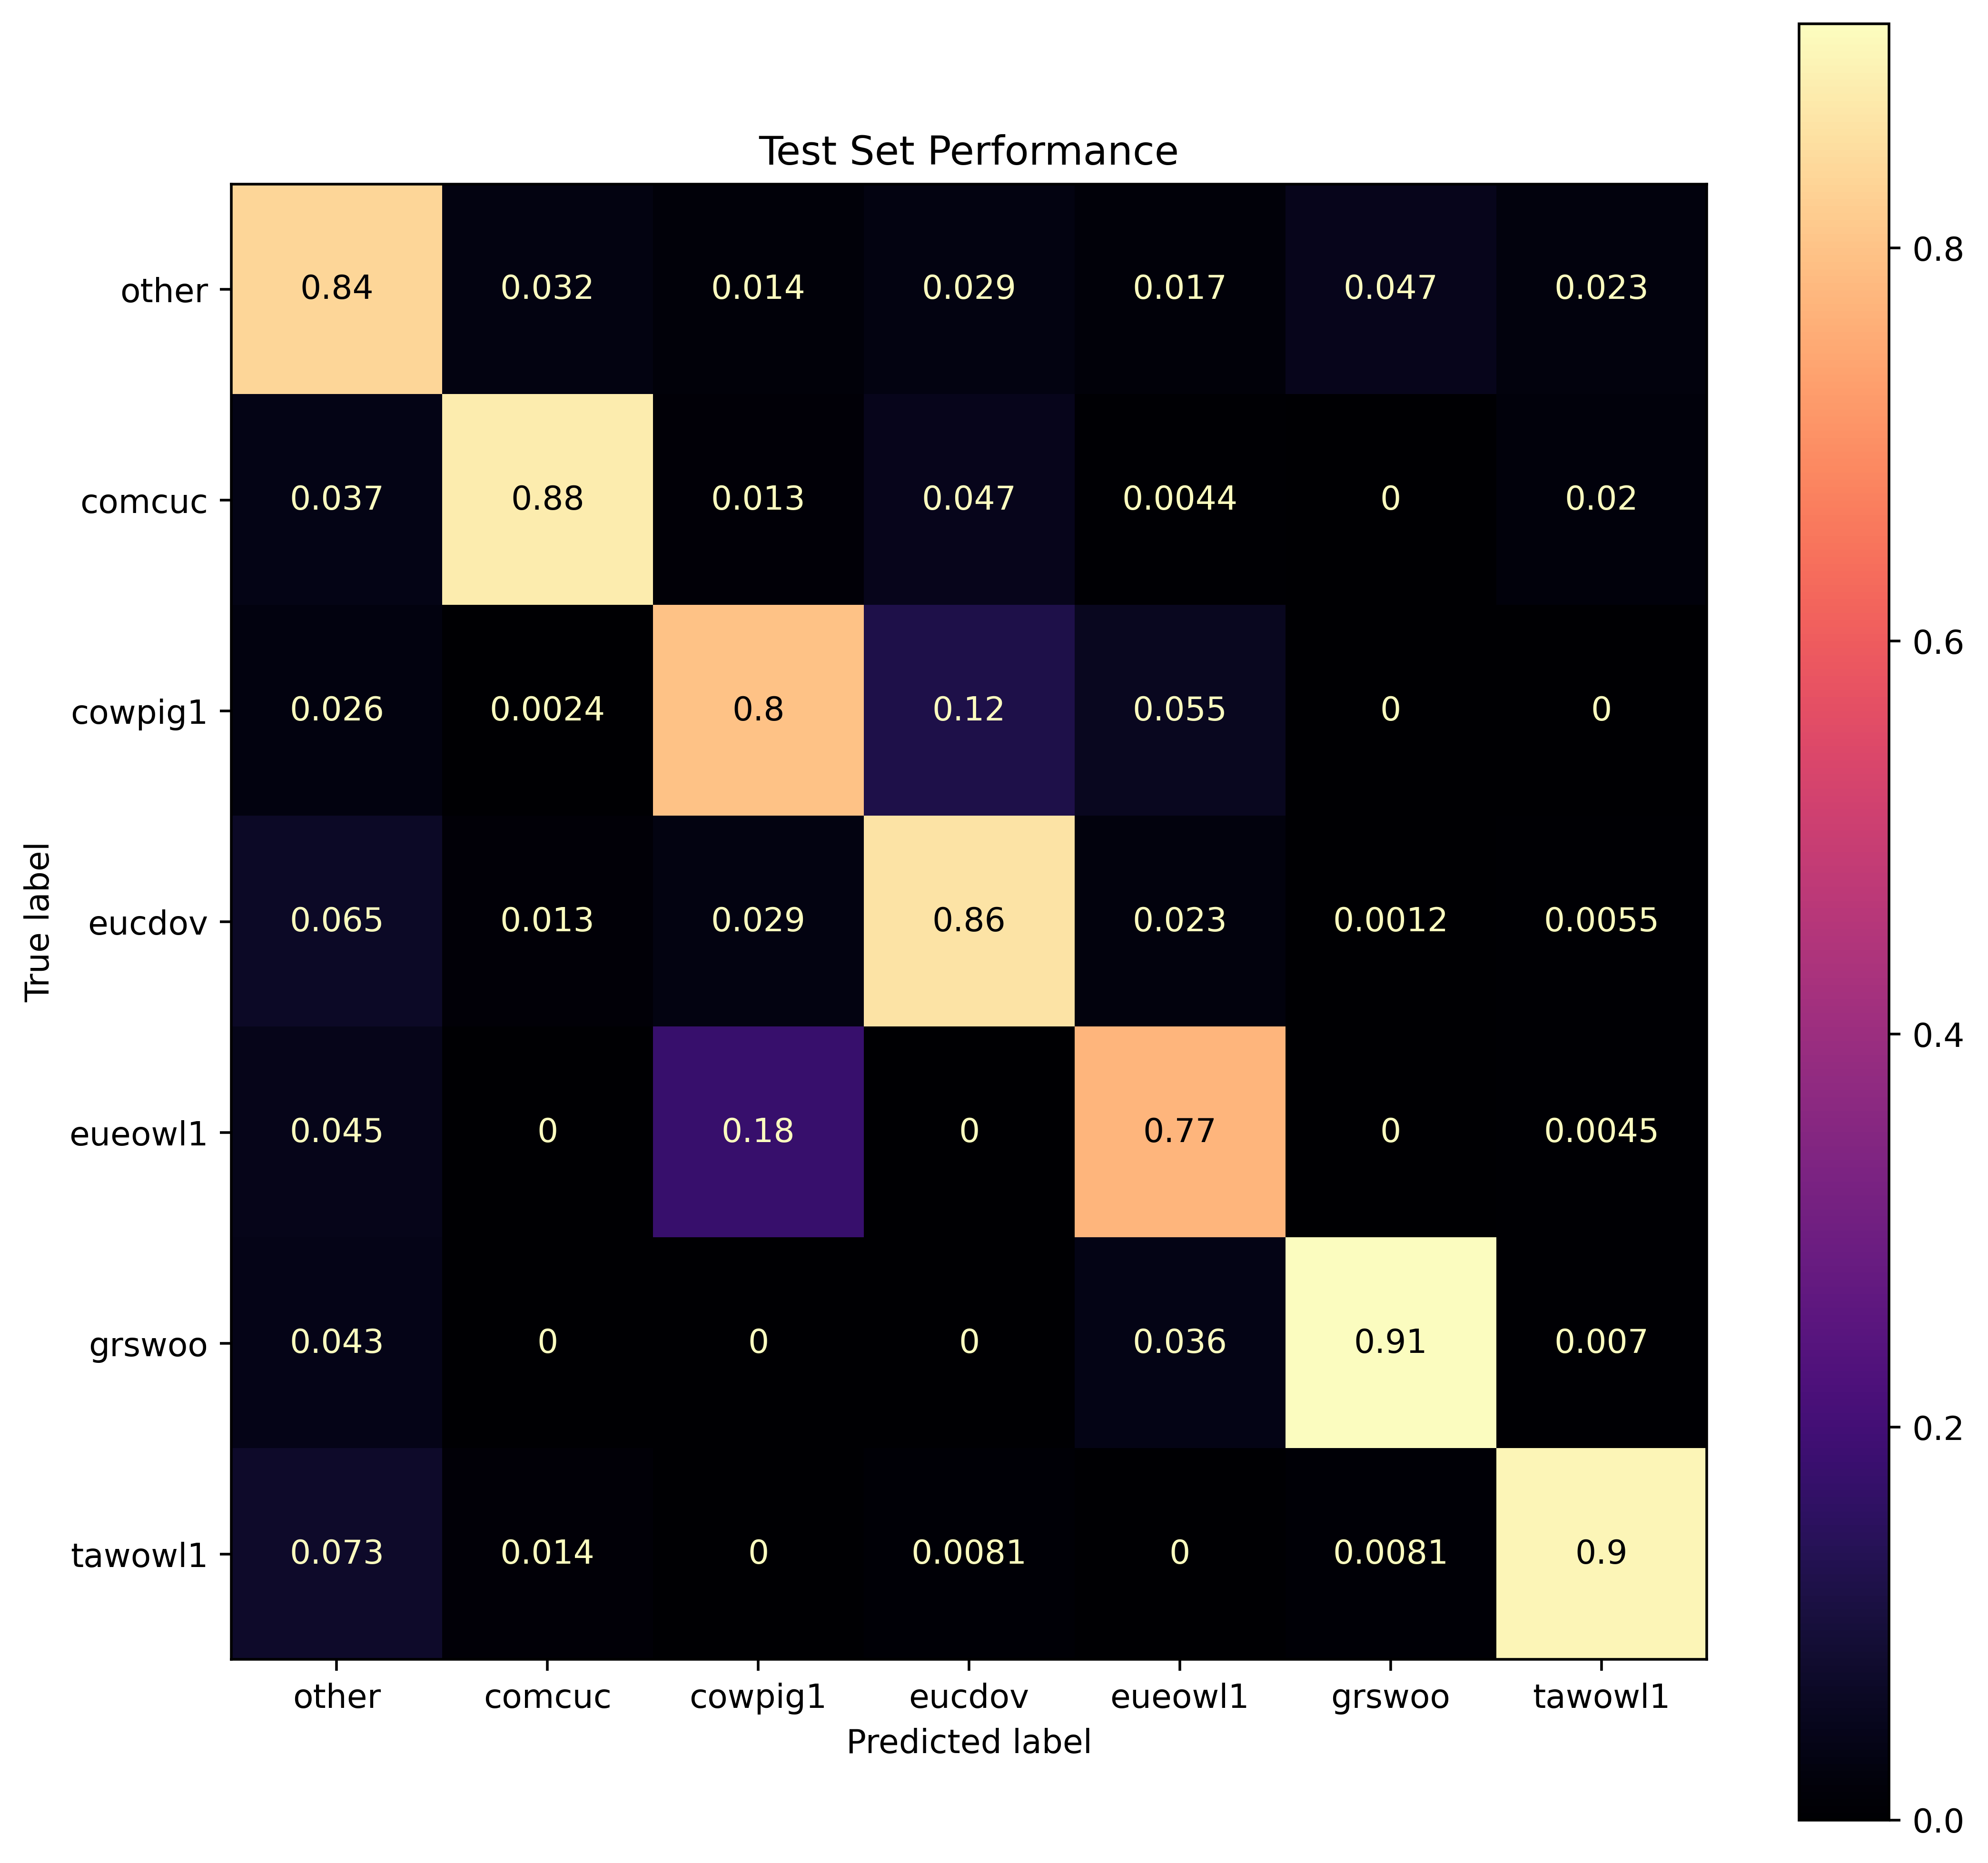

training_run_metrics[-1][0] = avg_loss = 0.000043, num_samples = 96000, num_correct = 82226, acc = 0.856521, bacc = 0.960137
test_metrics                = avg_loss = 0.000180, num_samples = 24000, num_correct = 20245, acc = 0.843542, bacc = 0.851831


In [49]:
set_random_seed(42)

data_train_normalized, data_test_normalized, normalization_scaler = normalize_data(data_train, data_test)

attention_classifier, training_run_metrics = train_attention_classifier(
    hyper_parameters, 
    training_hyper_parameters, 
    NumpyDataset(data_train_normalized, labels_train),
    NumpyDataset(data_test_normalized, labels_test),
    device
)

test_loader = create_data_loader(data_test_normalized, labels_test)
test_metrics = evaluate_attention_classifier(
    attention_classifier, 
    test_loader, 
    device, 
    show_confmat = True,
    confmat_title = 'Test Set Performance'
)

print(f'{training_run_metrics[-1][0] = }')
print(f'{test_metrics                = }')

In [48]:
# save_model(attention_classifier, 'attention_classifier bacc-0.856688')

'saved_models\\attention_classifier bacc-0.856688.pt'

In [35]:
# load_model('attention_classifier fold-1')
# TODO: normalization
test_loader = create_data_loader(data_test_normalized, labels_test)
test_attention_classifier(load_model('cv1/attention_classifier fold-0'), test_loader, device)

NameError: name 'data_test_normalized' is not defined